In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [38]:
# 데이터 로드
df = pd.read_csv('flights_sample_3m.csv')

# FL_DATE 열을 문자열 형식으로 변환 (yyyyMMdd 형태로 되어 있으므로 앞 4자리만 사용)
df["FL_DATE"] = df["FL_DATE"].astype(str)

# 2023년 데이터 제거 (FL_DATE 열의 앞 4자리가 '2023'인 행 제거)
df = df[~df["FL_DATE"].str.startswith("2023")]

# 항공사별 비행 횟수 계산
flight_counts = df['AIRLINE_CODE'].value_counts()

# 상위 10개를 선택하여 DataFrame 생성
top_10_airlines = flight_counts.head(10).reset_index()
top_10_airlines.columns = ['AIRLINE_CODE', 'FLIGHT_COUNT']

# 상위 10개 항공사의 데이터만 필터링
df = df[df['AIRLINE_CODE'].isin(top_10_airlines['AIRLINE_CODE'])]

## 1. 출발 시간과 도착 시간 지연 점수

#### 시간대별 지연 패턴

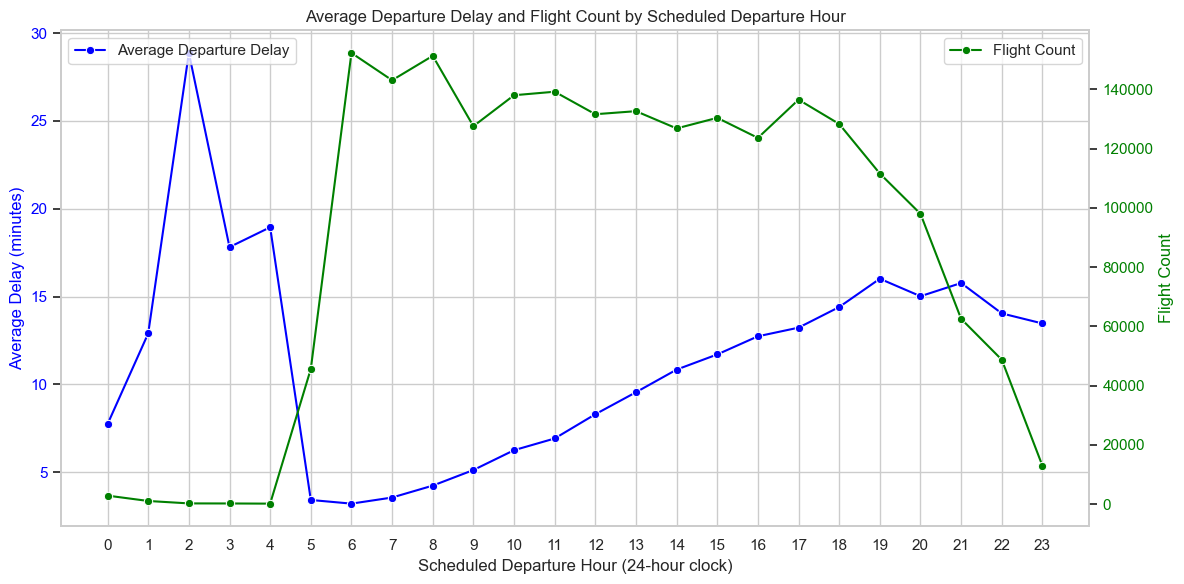

In [39]:
# 출발 예정 시간을 시간대로 변환 (hhmm → hour)
df['CRS_DEP_HOUR'] = df['CRS_DEP_TIME'] // 100

# 시간대별 평균 출발 지연 시간 및 항공편 수 계산
dep_delay_by_hour = df.groupby('CRS_DEP_HOUR')['DEP_DELAY'].mean().reset_index()
flight_count_by_hour = df.groupby('CRS_DEP_HOUR')['FL_DATE'].count().reset_index()
flight_count_by_hour.rename(columns={'FL_DATE': 'FLIGHT_COUNT'}, inplace=True)

# 이중 축 그래프 생성
fig, ax1 = plt.subplots(figsize=(12, 6))

# 평균 출발 지연 시간 선 그래프 (왼쪽 y축)
sns.lineplot(
    data=dep_delay_by_hour, 
    x='CRS_DEP_HOUR', 
    y='DEP_DELAY', 
    marker='o', 
    color='blue', 
    label='Average Departure Delay', 
    ax=ax1
)
ax1.set_xlabel('Scheduled Departure Hour (24-hour clock)')
ax1.set_ylabel('Average Delay (minutes)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(0, 24))  # 시간대를 0~23으로 설정

# 항공편 수 막대그래프 (오른쪽 y축)
ax2 = ax1.twinx()  # 공유 x축
sns.lineplot(
    data=flight_count_by_hour, 
    x='CRS_DEP_HOUR', 
    y='FLIGHT_COUNT', 
    marker='o', 
    color='green', 
    label='Flight Count', 
    ax=ax2
)
ax2.set_ylabel('Flight Count', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 제목 및 레이아웃
plt.title('Average Departure Delay and Flight Count by Scheduled Departure Hour')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()

plt.tight_layout()
plt.show()


#### 항공사별 출발, 도착 지연 시간 및 총합

/var/folders/qt/6zfp3p4j4v10mzbh5ffczxv00000gn/T/ipykernel_36866/333455023.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


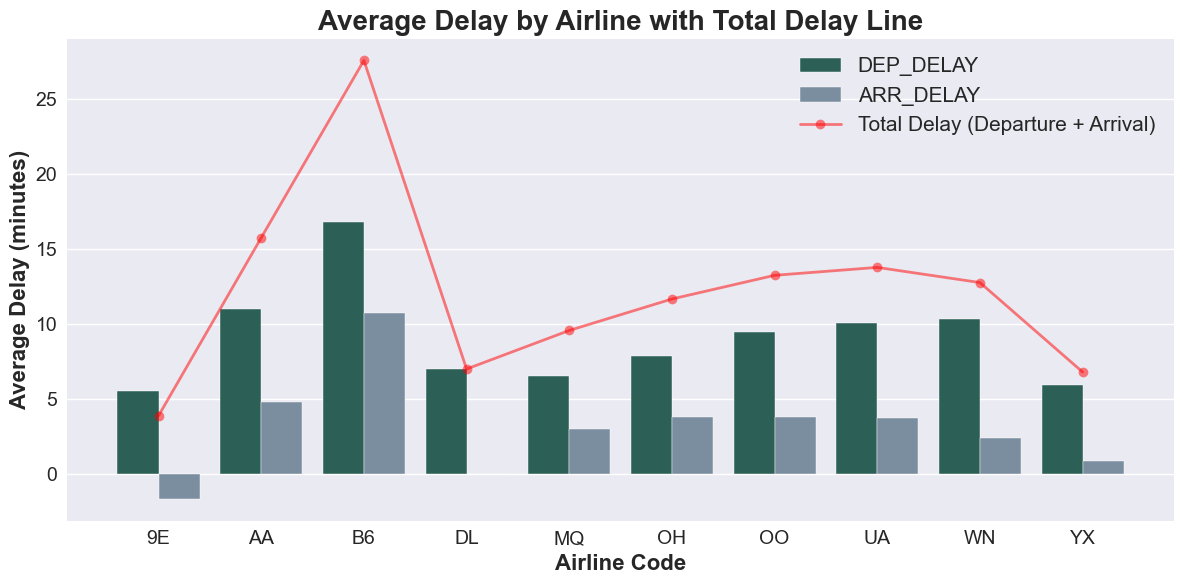

In [40]:
plt.style.use('seaborn')

# 항공사별 평균 출발, 도착 지연 시간 및 총 지연 시간 계산
airline_delay = df.groupby('AIRLINE_CODE')[['DEP_DELAY', 'ARR_DELAY']].mean().reset_index()
airline_delay['TOTAL_DELAY'] = airline_delay['DEP_DELAY'] + airline_delay['ARR_DELAY']

# 데이터 변환: melt를 사용해 긴 형식으로 변경 (출발/도착 지연만 포함)
airline_delay_melted = airline_delay.melt(
    id_vars='AIRLINE_CODE', 
    value_vars=['DEP_DELAY', 'ARR_DELAY'], 
    var_name='Type', 
    value_name='Average_Delay'
)

# 막대그래프 그리기 (출발 지연, 도착 지연만 포함)
plt.figure(figsize=(12, 6))
sns.barplot(data=airline_delay_melted, x='AIRLINE_CODE', y='Average_Delay', hue='Type', 
            palette={'DEP_DELAY': '#23695d', 'ARR_DELAY': '#748ea6'})

# 총 지연 시간 라인 그래프 그리기
plt.plot(
    airline_delay['AIRLINE_CODE'], 
    airline_delay['TOTAL_DELAY'], 
    color='red', 
    marker='o', 
    linewidth=2, 
    label='Total Delay (Departure + Arrival)',
    alpha=.5
)

# 그래프 설정
plt.title('Average Delay by Airline with Total Delay Line', fontsize=20, fontweight='bold')
plt.xlabel('Airline Code', fontsize=16, fontweight='bold')
plt.ylabel('Average Delay (minutes)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()


/var/folders/qt/6zfp3p4j4v10mzbh5ffczxv00000gn/T/ipykernel_36866/308548823.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


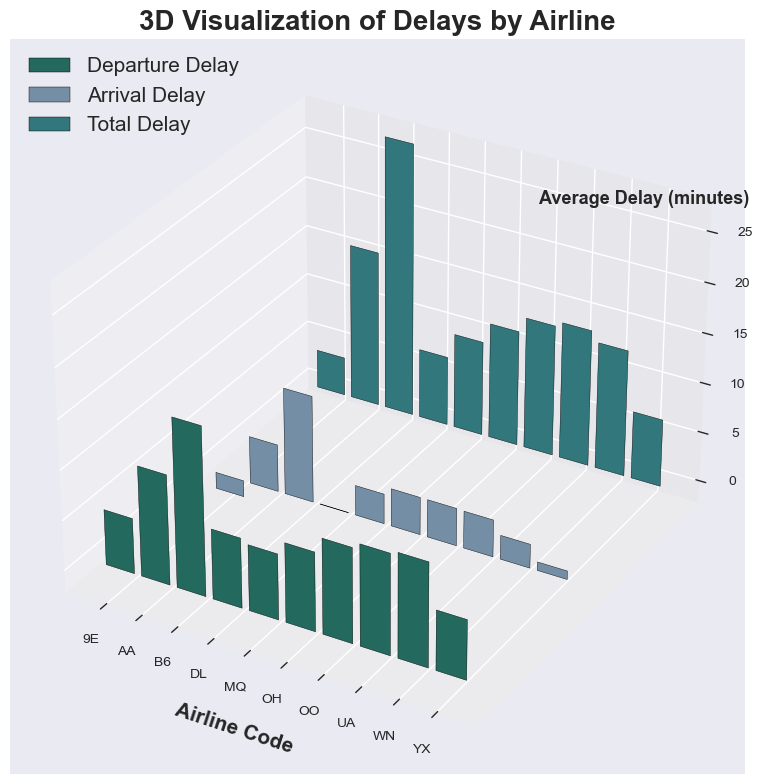

In [41]:
plt.style.use('seaborn')

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# 데이터 설정
x = airline_delay['AIRLINE_CODE']
y = ['Departure Delay', 'Arrival Delay', 'Total Delay']
z = [0, 1, 2]  # 층별 분리
colors = ['#23695d', '#748ea6', '#32777c']
delay_values = [airline_delay['DEP_DELAY'], airline_delay['ARR_DELAY'], airline_delay['TOTAL_DELAY']]

# 각 항공사별 층별 지연 시각화
for i, (z_val, color, delay) in enumerate(zip(z, colors, delay_values)):
    ax.bar(
        x, 
        delay, 
        zs=z_val, 
        zdir='y', 
        color=color, 
        alpha=1, 
        edgecolor='black', 
        label=y[i]
    )

# 그래프 제목 및 설정
ax.set_title('3D Visualization of Delays by Airline', fontsize=20, fontweight='bold')
ax.set_xlabel('Airline Code', fontsize=15, fontweight='bold', labelpad=15)  # X축 라벨 간격 조정

# Z축 레이블 위치 조정 (텍스트로 직접 배치)
ax.text(x=7.5, y=2.5, z=22, s='Average Delay (minutes)', fontsize=13, ha='center', va='bottom', fontweight='bold')

# Y축 ticks 제거
ax.set_yticks([])

# 범례 및 레이아웃
ax.legend(loc='upper left', fontsize=15)
plt.tight_layout()

# 출력
plt.show()

/var/folders/qt/6zfp3p4j4v10mzbh5ffczxv00000gn/T/ipykernel_36866/3518464673.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


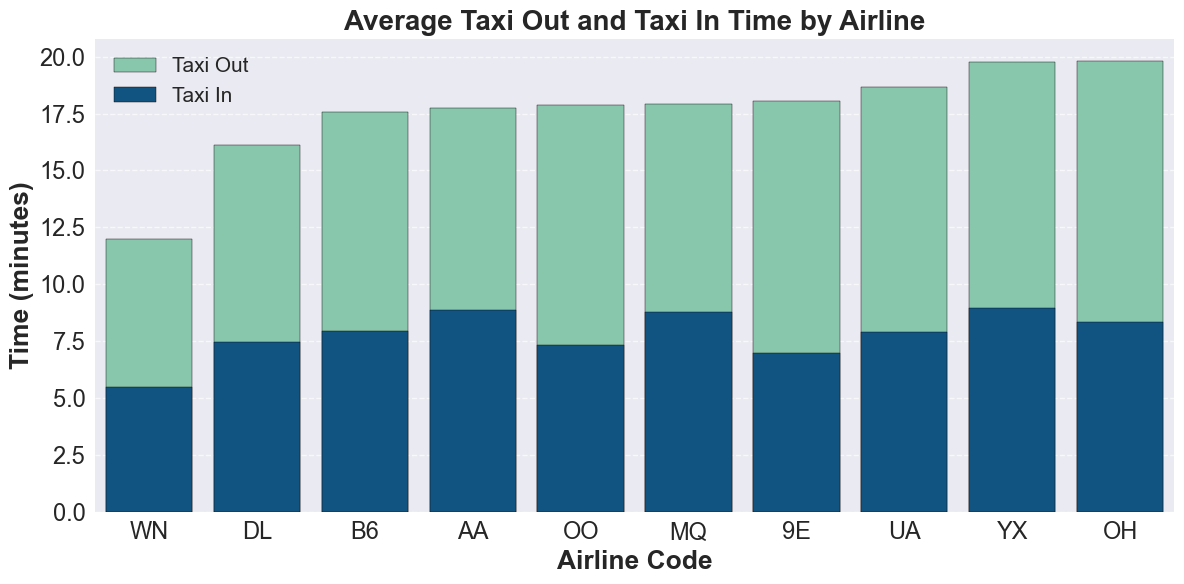

In [42]:
plt.style.use('seaborn')
taxi_times_by_airline = df.groupby('AIRLINE_CODE')[['TAXI_OUT', 'TAXI_IN']].mean().reset_index()

taxi_times_by_airline_sorted = taxi_times_by_airline.sort_values(by='TAXI_OUT', ascending=True)

plt.figure(figsize=(12, 6))

sns.barplot(data=taxi_times_by_airline_sorted, x='AIRLINE_CODE', y='TAXI_OUT', color='#7fd1ae', label='Taxi Out', edgecolor='black')

sns.barplot(data=taxi_times_by_airline_sorted, x='AIRLINE_CODE', y='TAXI_IN', color='#005893', label='Taxi In', edgecolor='black')

plt.title('Average Taxi Out and Taxi In Time by Airline', fontsize=20, fontweight='bold')
plt.xlabel('Airline Code', fontsize=19, fontweight='bold')
plt.ylabel('Time (minutes)', fontsize=19, fontweight='bold')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.legend(fontsize=15)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()


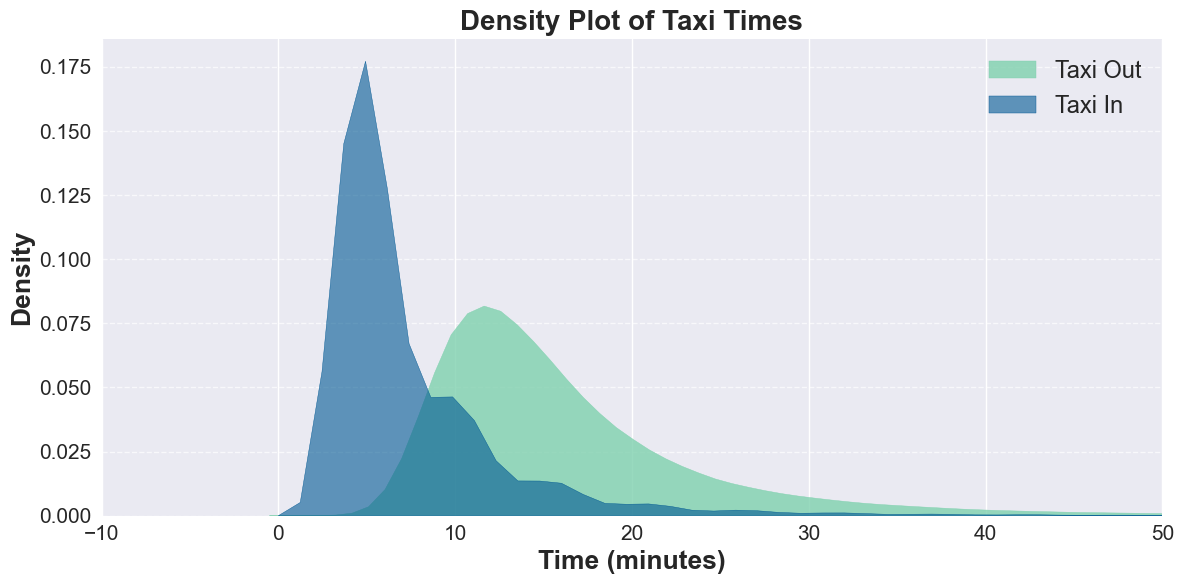

In [43]:
plt.figure(figsize=(12, 6))

sns.kdeplot(df['TAXI_OUT'], color='#7fd1ae', label='Taxi Out', fill=True, alpha=0.8)
sns.kdeplot(df['TAXI_IN'], color='#005893', label='Taxi In', fill=True, alpha=0.6)

plt.title('Density Plot of Taxi Times', fontsize=20, fontweight='bold')
plt.xlabel('Time (minutes)', fontsize=19, fontweight='bold')
plt.ylabel('Density', fontsize=19, fontweight='bold')
plt.legend(fontsize=17)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# x축 범위 설정
plt.xlim(-10, 50)

plt.tight_layout()
plt.show()

/var/folders/qt/6zfp3p4j4v10mzbh5ffczxv00000gn/T/ipykernel_36866/1716551656.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


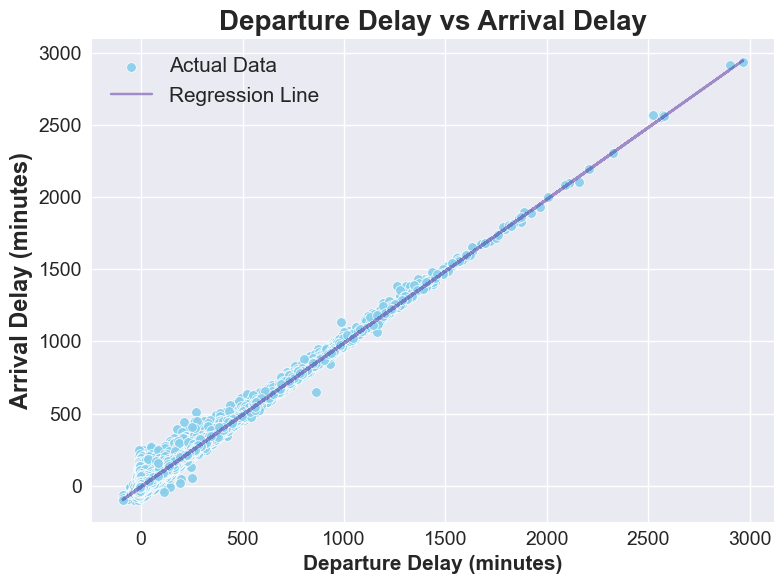

In [44]:
plt.style.use('seaborn')
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['DEP_DELAY'], y=df['ARR_DELAY'], alpha=0.9, color='skyblue', label='Actual Data')
plt.plot(df['DEP_DELAY'], y_pred, color='#542d9e', label='Regression Line', alpha=.5)
plt.title('Departure Delay vs Arrival Delay', fontsize=20, fontweight='bold')
plt.xlabel('Departure Delay (minutes)', fontsize=15, fontweight='bold')
plt.ylabel('Arrival Delay (minutes)', fontsize=17, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

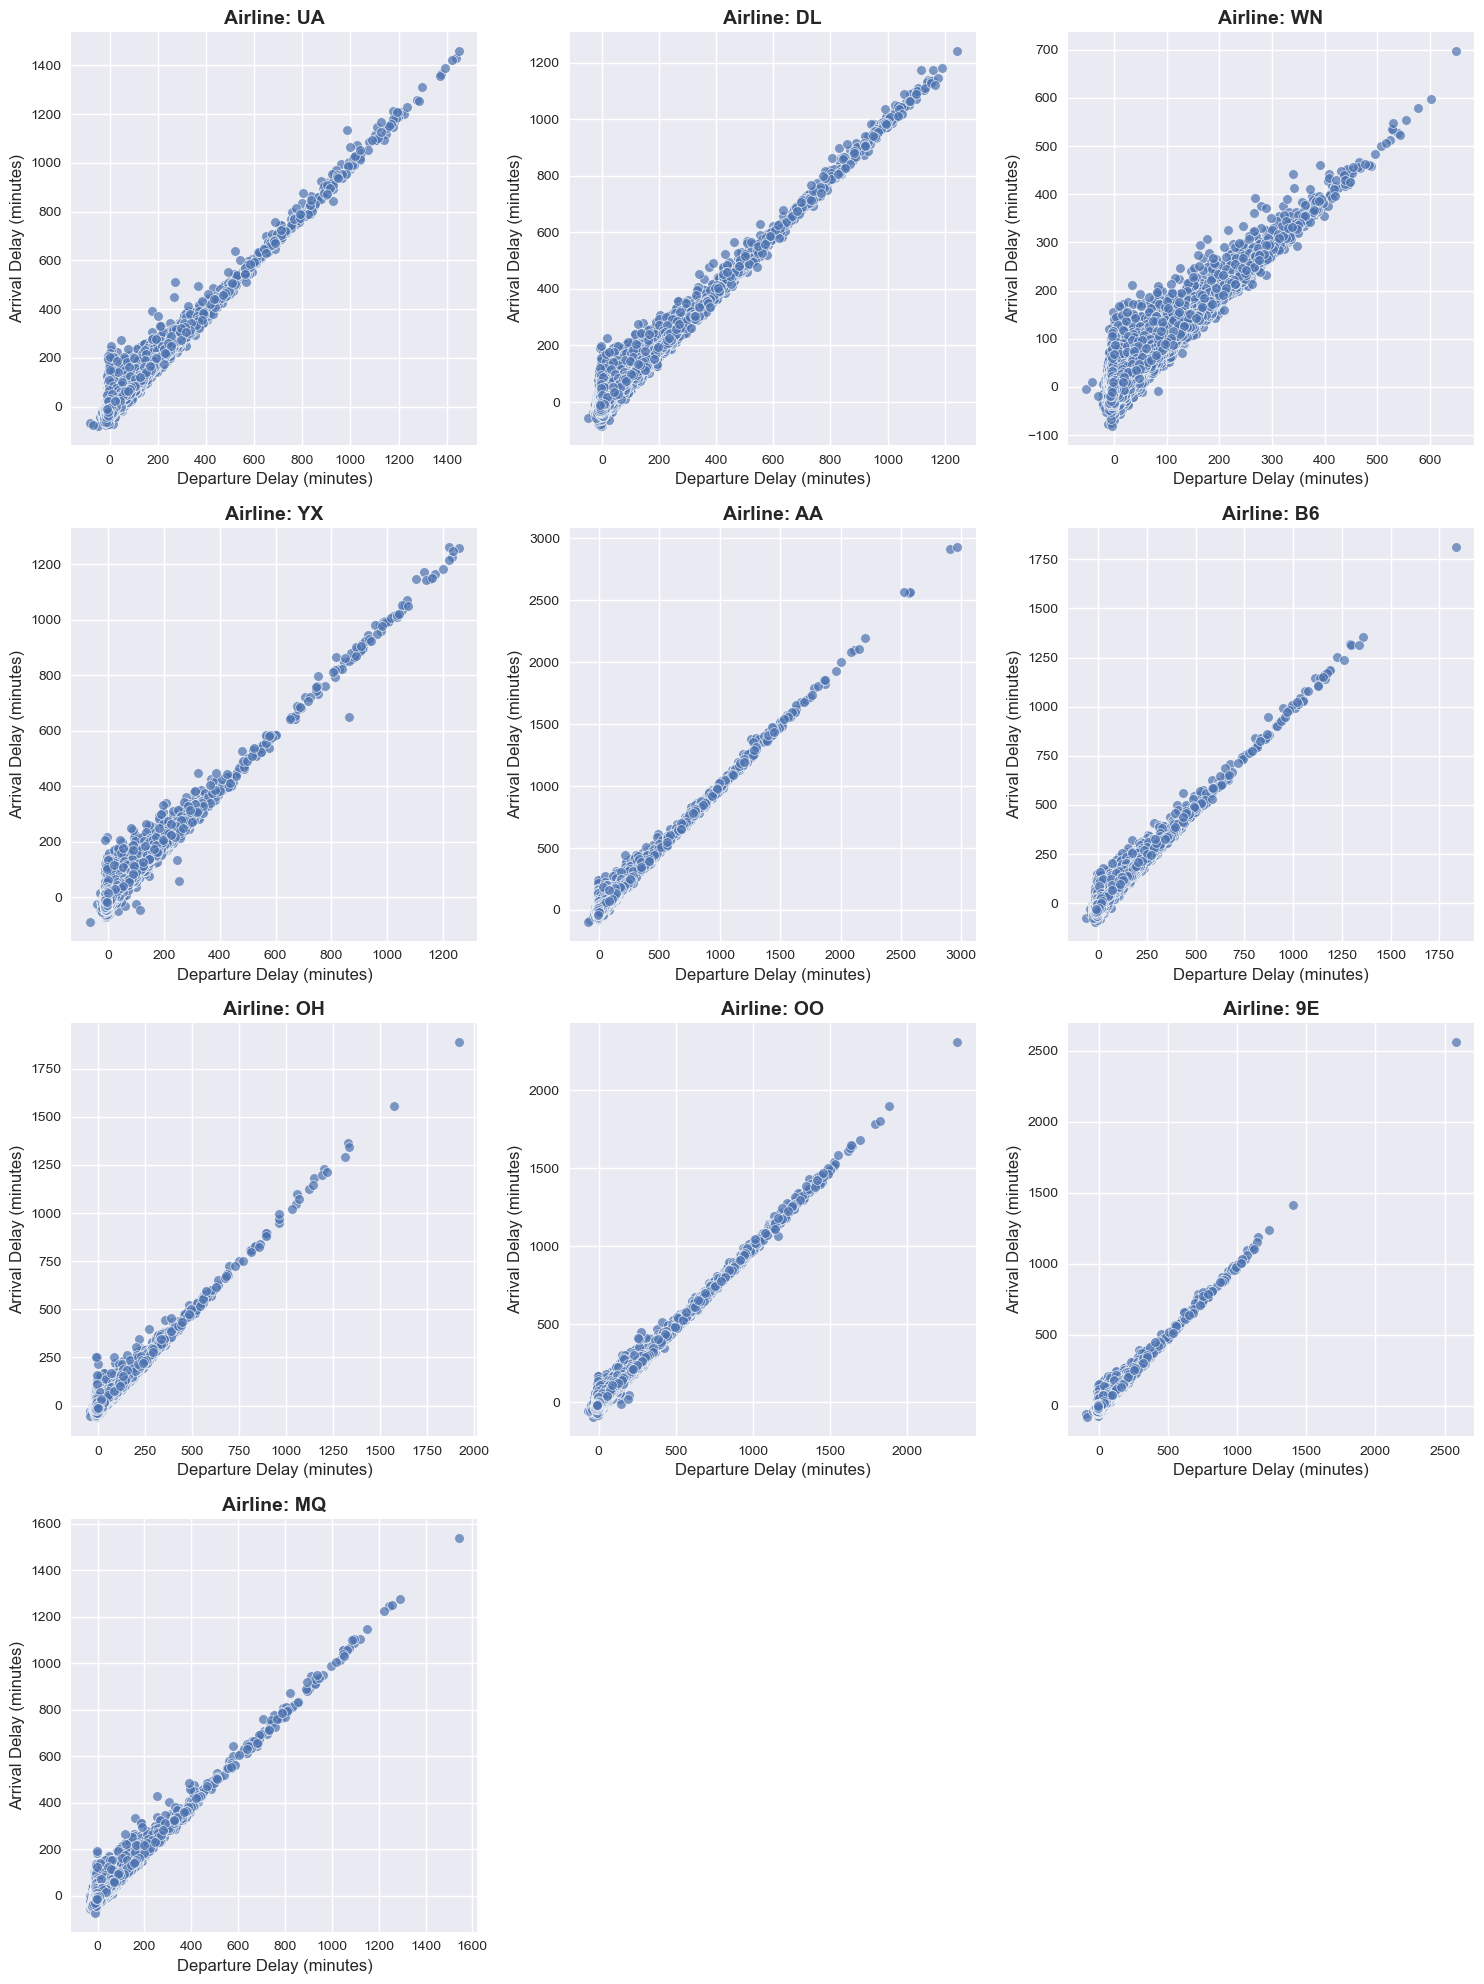

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

airlines = df['AIRLINE_CODE'].unique()
n_cols = 3
n_rows = -(-len(airlines) // n_cols)  # 올림 연산으로 행 개수 결정

plt.figure(figsize=(15, 5 * n_rows))
for idx, airline in enumerate(airlines):
    plt.subplot(n_rows, n_cols, idx + 1)
    airline_data = df[df['AIRLINE_CODE'] == airline]
    sns.scatterplot(x=airline_data['DEP_DELAY'], y=airline_data['ARR_DELAY'], alpha=0.7)
    plt.title(f'Airline: {airline}', fontsize=14, fontweight='bold')
    plt.xlabel('Departure Delay (minutes)', fontsize=12)
    plt.ylabel('Arrival Delay (minutes)', fontsize=12)

plt.tight_layout()
plt.show()

/var/folders/qt/6zfp3p4j4v10mzbh5ffczxv00000gn/T/ipykernel_36866/425156950.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


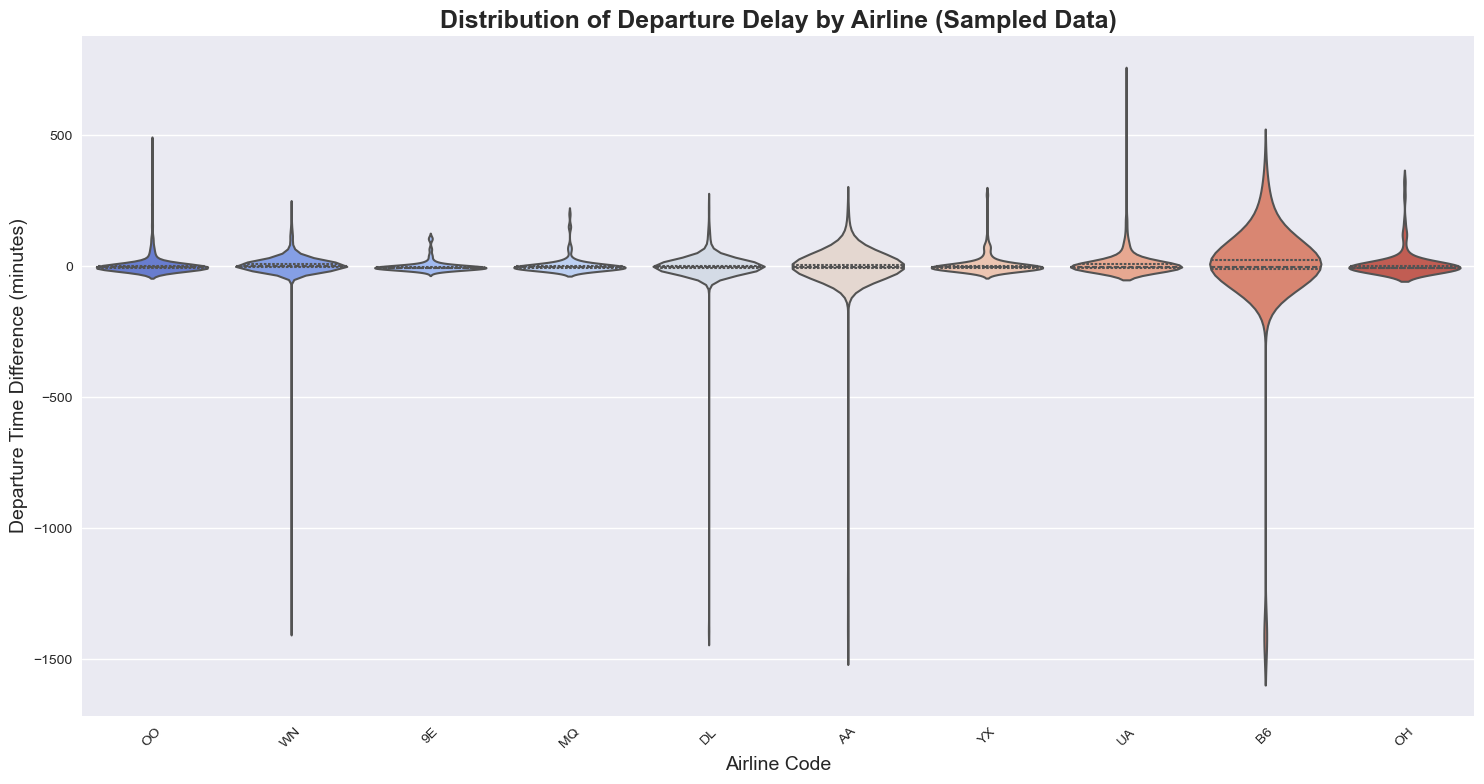

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 표본 추출 (전체 데이터의 10%를 랜덤으로 선택)
df_sample = df.sample(frac=0.001, random_state=42)

# 'hhmm' 형식을 분 단위로 변환하는 함수
def time_to_minutes(time):
    hours = time // 100  # 시
    minutes = time % 100  # 분
    return hours * 60 + minutes

# DEP_TIME과 CRS_DEP_TIME을 분 단위로 변환
df_sample['DEP_TIME_MINUTES'] = df_sample['DEP_TIME'].apply(time_to_minutes)
df_sample['CRS_DEP_TIME_MINUTES'] = df_sample['CRS_DEP_TIME'].apply(time_to_minutes)

# 실제 출발 시간과 원래 출발 시간의 차이 계산
df_sample['DEP_TIME_DIFF'] = df_sample['DEP_TIME_MINUTES'] - df_sample['CRS_DEP_TIME_MINUTES']

# 각 항공사별 바이올린 플롯 시각화
plt.figure(figsize=(15, 8))
sns.violinplot(
    x='AIRLINE_CODE',  # 항공사별로 그룹화
    y='DEP_TIME_DIFF',  # 실제 출발 시간과 원래 출발 시간의 차이
    data=df_sample,
    palette='coolwarm',  # 색상 팔레트
    inner='quart',  # 사분위수를 나타내는 내부 표시
    linewidth=1.5
)

plt.title('Distribution of Departure Delay by Airline (Sampled Data)', fontsize=18, fontweight='bold')
plt.xlabel('Airline Code', fontsize=14)
plt.ylabel('Departure Time Difference (minutes)', fontsize=14)
plt.xticks(rotation=45)  # 항공사 코드 레이블 회전
plt.tight_layout()
plt.show()

#### 출발 시간과 도착 시간 지연 점수

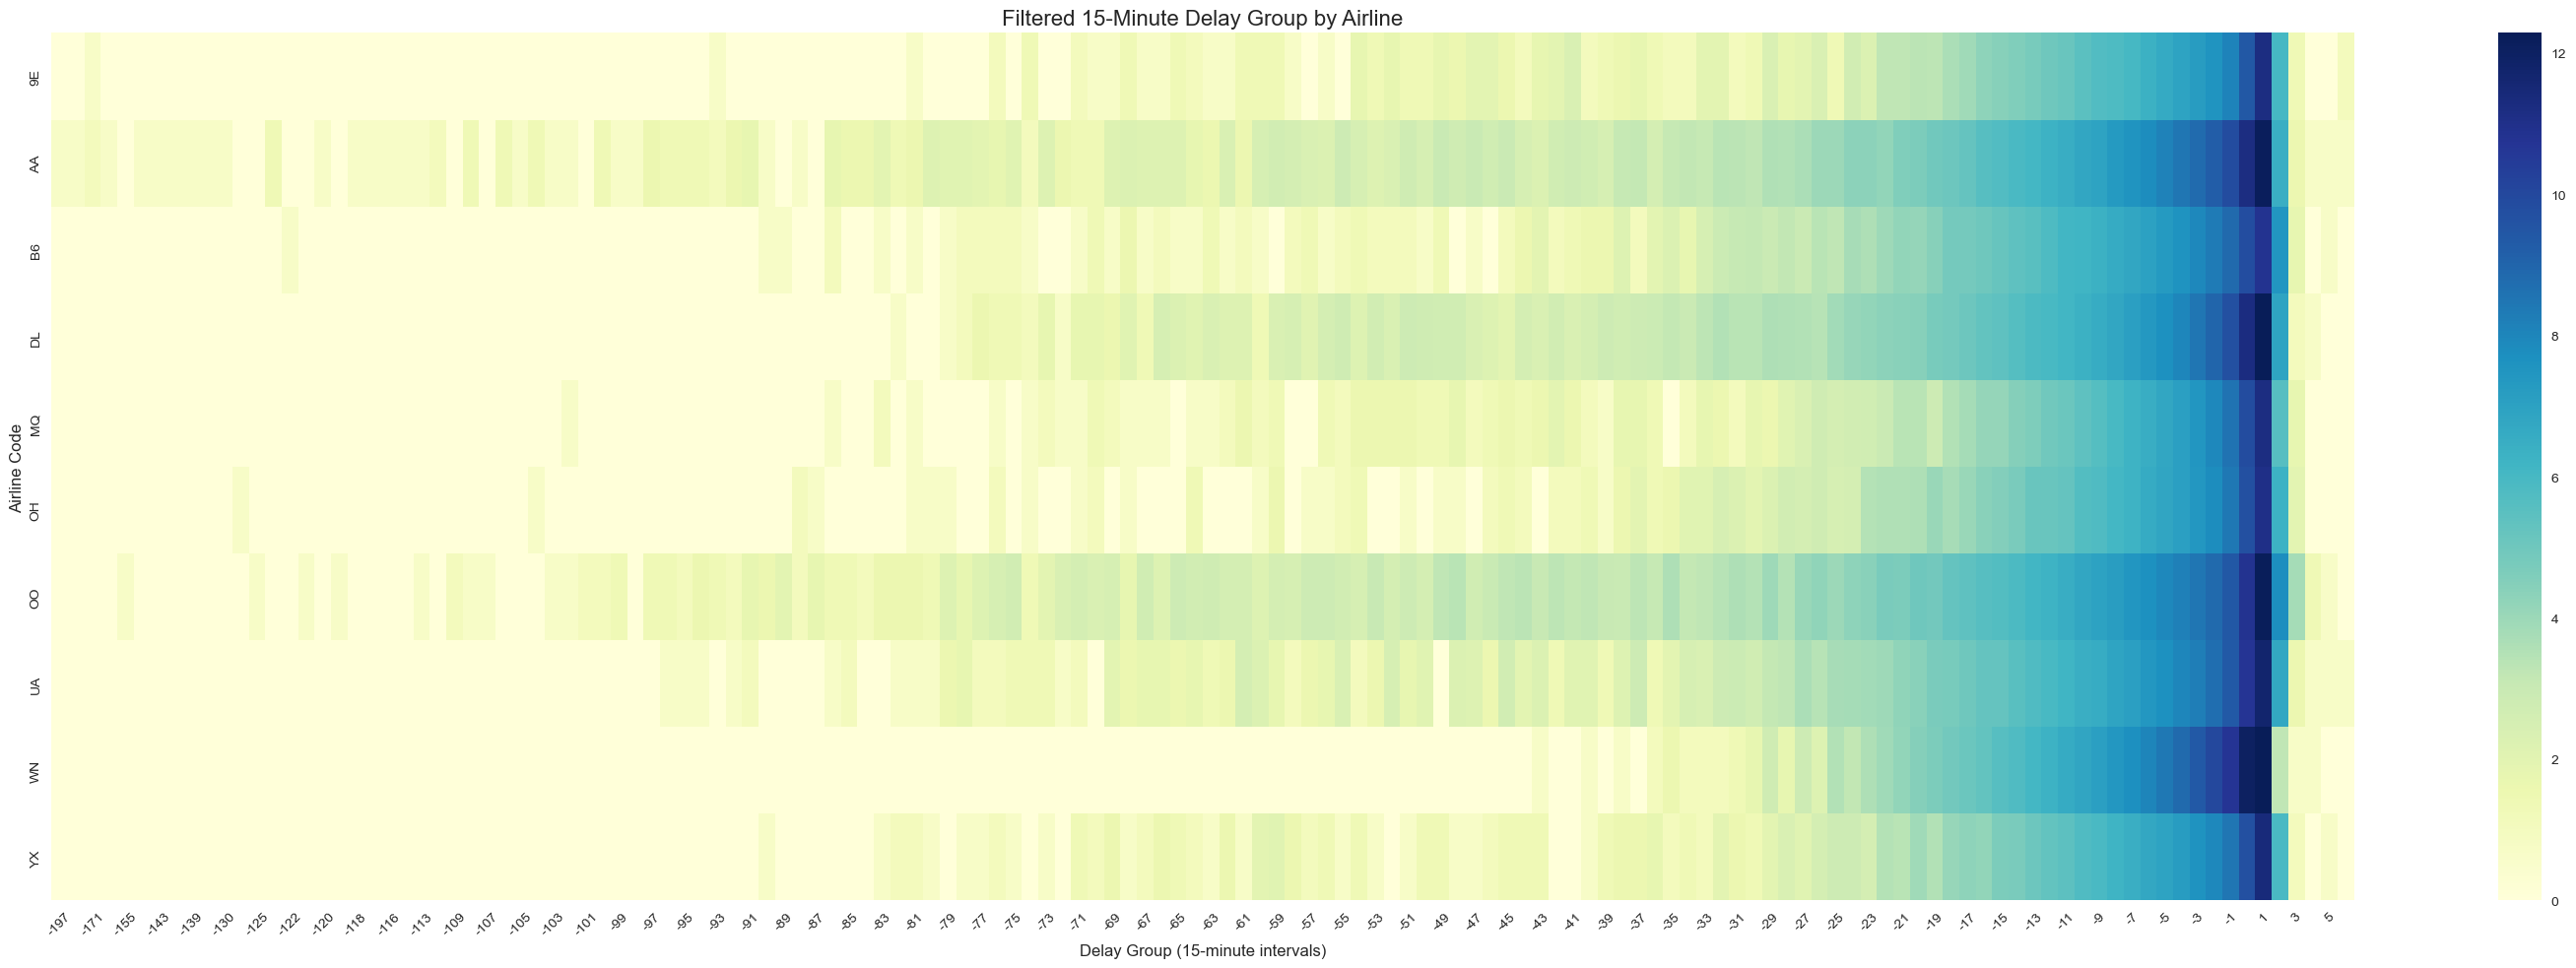

In [47]:
# NaN 값 처리 (DEP_DELAY가 없는 경우 0으로 간주)
df['DEP_DELAY'] = df['DEP_DELAY'].fillna(0)

# 15분 단위로 지연 시간 그룹화
df['DELAY_GROUP'] = (df['DEP_DELAY'] // 15).astype(int)

# 15분 단위 지연 그룹에 -1 점수를 부여
df['DELAY_GROUP'] = df['DELAY_GROUP'] * -1

# 항공사별 지연 그룹별 항공편 수 계산
delay_airline_counts = df.groupby(['AIRLINE_CODE', 'DELAY_GROUP']).size().unstack(fill_value=0)

# 값이 모두 0인 행(항공사) 제거
delay_airline_counts = delay_airline_counts.loc[(delay_airline_counts != 0).any(axis=1), :]

# **로그 스케일 변환** (시각화 대비 향상)
import numpy as np
delay_airline_counts_log = np.log1p(delay_airline_counts)  # log(1 + x) 적용

# 히트맵 시각화
plt.figure(figsize=(30, 10))
sns.heatmap(delay_airline_counts_log, cmap="YlGnBu", annot=False, fmt=".0f", cbar=True)

# 그래프 제목 및 축 레이블 설정
plt.title('Filtered 15-Minute Delay Group by Airline', fontsize=16)
plt.xlabel('Delay Group (15-minute intervals)', fontsize=12)
plt.ylabel('Airline Code', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()

/var/folders/qt/6zfp3p4j4v10mzbh5ffczxv00000gn/T/ipykernel_36866/2722620704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_recovery['DELAY_RECOVERY_SCORE'] = (df_filtered_recovery['DELAY_RECOVERY'] // 15).astype(int)
/Users/whereismyschool/anaconda3/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.draw()
/Users/whereismyschool/anaconda3/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from current font.
  fig.canvas.draw()
/Users/whereismyschool/anaconda3/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.

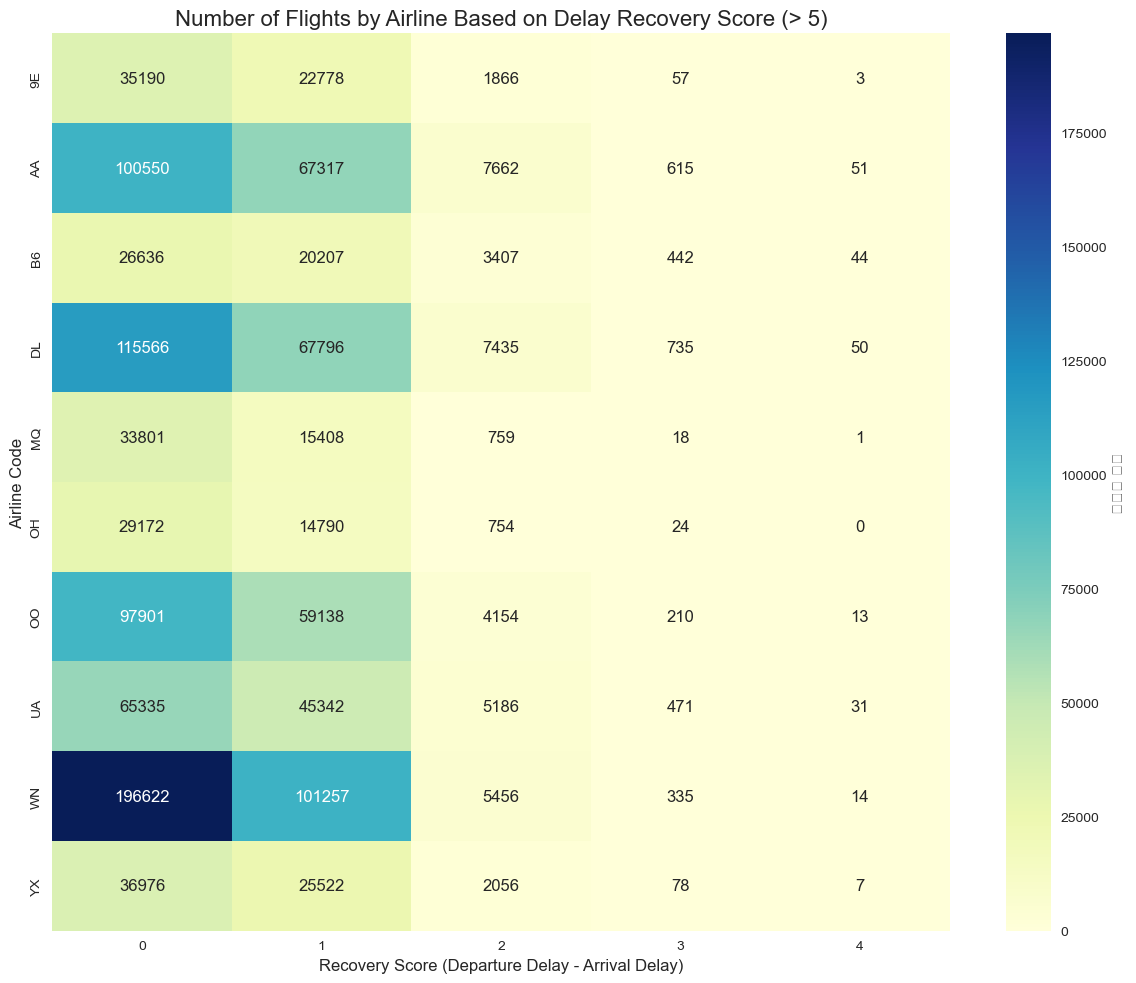

In [48]:
# 출발 지연과 도착 지연의 차이 계산 (출발 지연 - 도착 지연)
df['DELAY_RECOVERY'] = df['DEP_DELAY'] - df['ARR_DELAY']

# DELAY_RECOVERY > 5인 값만 필터링
df_filtered_recovery = df[df['DELAY_RECOVERY'] > 5]

# 15분 단위로 구간화 (점수화)
df_filtered_recovery['DELAY_RECOVERY_SCORE'] = (df_filtered_recovery['DELAY_RECOVERY'] // 15).astype(int)

# 항공사별로 DELAY_RECOVERY_SCORE의 분포를 기준으로 비행기 개수를 계산
delay_airline_counts = df_filtered_recovery.groupby(['AIRLINE_CODE', 'DELAY_RECOVERY_SCORE']).size().unstack(fill_value=0)

# DELAY_RECOVERY_SCORE가 5 이하인 부분을 제거 (즉, 5 이하인 값은 제거)
delay_airline_counts = delay_airline_counts.loc[:, delay_airline_counts.columns < 5]

# 값이 모두 0인 행(항공사) 제거
delay_airline_counts = delay_airline_counts.loc[(delay_airline_counts != 0).any(axis=1), :]

# 히트맵 시각화
plt.figure(figsize=(12, 10))  # figsize 설정은 여기에서만 하면 됩니다.

sns.heatmap(delay_airline_counts, annot=True, cmap='YlGnBu', fmt='.0f', cbar_kws={'label': '비행기 개수'})

# 그래프 제목 및 축 레이블 설정
plt.title('Number of Flights by Airline Based on Delay Recovery Score (> 5)', fontsize=16)
plt.xlabel('Recovery Score (Departure Delay - Arrival Delay)', fontsize=12)  
plt.ylabel('Airline Code', fontsize=12) 
plt.tight_layout()

# 그래프 출력
plt.show()

### 택시인과 택시아웃

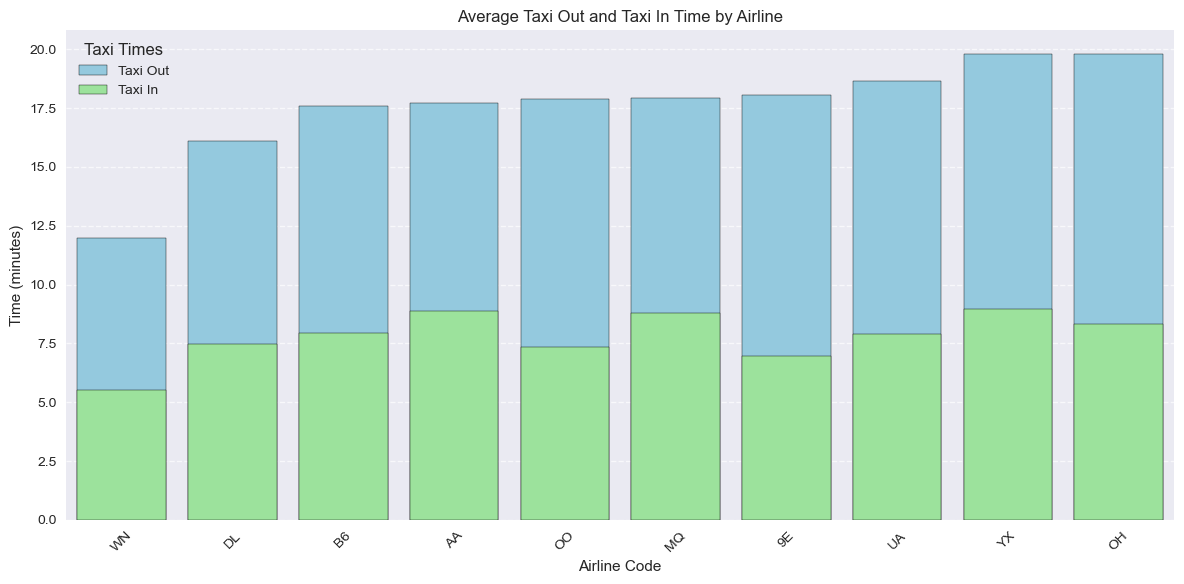

In [49]:
axi_times_by_airline = df.groupby('AIRLINE_CODE')[['TAXI_OUT', 'TAXI_IN']].mean().reset_index()

taxi_times_by_airline_sorted = taxi_times_by_airline.sort_values(by='TAXI_OUT', ascending=True)

plt.figure(figsize=(12, 6))

sns.barplot(data=taxi_times_by_airline_sorted, x='AIRLINE_CODE', y='TAXI_OUT', color='skyblue', label='Taxi Out', edgecolor='black')

sns.barplot(data=taxi_times_by_airline_sorted, x='AIRLINE_CODE', y='TAXI_IN', color='lightgreen', label='Taxi In', edgecolor='black')

plt.title('Average Taxi Out and Taxi In Time by Airline')
plt.xlabel('Airline Code')
plt.ylabel('Time (minutes)')
plt.xticks(rotation=45)

plt.legend(title='Taxi Times')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

## 취소율

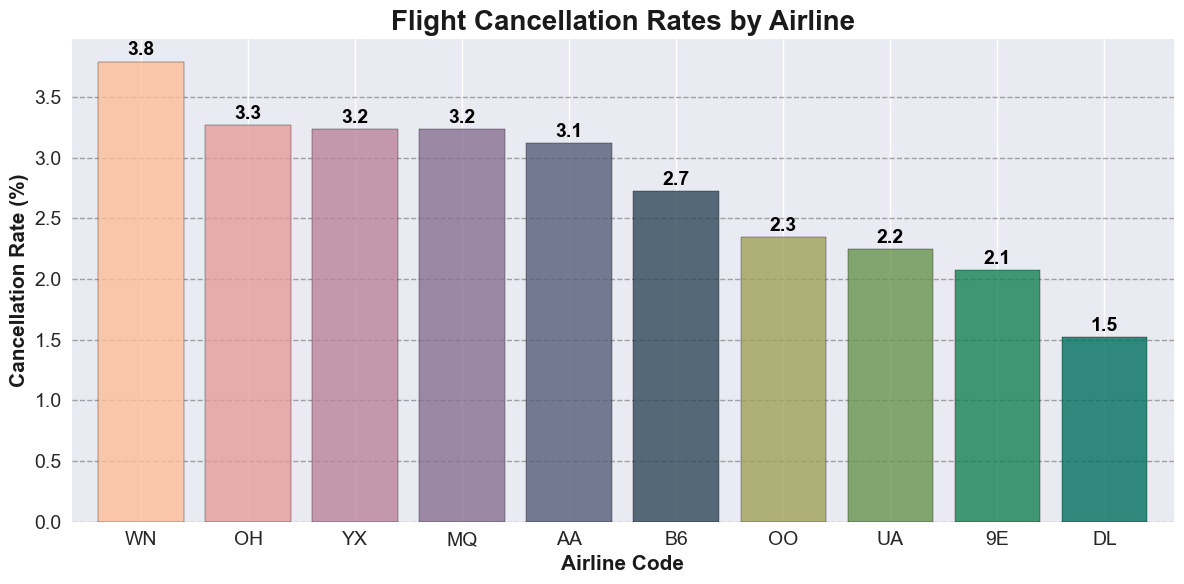

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# 색상 목록 직접 지정 (사용자가 원하는 색상 추가)
custom_colors = [
    "#febe98", "#e59c9b", "#ba839b", "#877091", "#555d79",  # 파란색 계열
    "#2f4858", "#a1a259", "#68944e", "#148352", "#00705e"   # 보라색 계열
]

# 항공사별 색상 할당 (취소율과 분산 비율에 사용되는 동일한 색상)
airline_colors = dict(zip(cancellation_rate.index, custom_colors[:len(cancellation_rate)]))

# 취소율 시각화
plt.figure(figsize=(12, 6))

# 바 차트에서 색상 매핑을 적용
ax = cancellation_rate.sort_values(ascending=False).plot(
    kind="bar", 
    color=[airline_colors[airline] for airline in cancellation_rate.index],  # 색상 매핑 적용
    edgecolor="black", 
    width=0.8,
    alpha=.8
)

# 그래프 제목 및 축 레이블
plt.title("Flight Cancellation Rates by Airline", fontsize=20, fontweight='bold', color='k')
plt.xlabel("Airline Code", fontsize=15, fontweight='bold', color='k')
plt.ylabel("Cancellation Rate (%)", fontsize=15, fontweight='bold', color='k')
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)

# 각 값 명시 (위쪽에 값 표시)
for idx, value in enumerate(cancellation_rate.sort_values(ascending=False)):
    ax.text(idx, value + 0.05, f"{value:.1f}", ha="center", fontsize=14, color='black', fontweight='bold')

# 그리드 추가 및 레이아웃 조정
plt.grid(axis="y", linestyle="--", alpha=0.7, color='gray')
plt.tight_layout()

# 그래프 출력
plt.show()

## 우회율

/var/folders/qt/6zfp3p4j4v10mzbh5ffczxv00000gn/T/ipykernel_36866/2750654478.py:63: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  plt.tight_layout()
/var/folders/qt/6zfp3p4j4v10mzbh5ffczxv00000gn/T/ipykernel_36866/2750654478.py:63: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  plt.tight_layout()
/var/folders/qt/6zfp3p4j4v10mzbh5ffczxv00000gn/T/ipykernel_36866/2750654478.py:63: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.tight_layout()
/var/folders/qt/6zfp3p4j4v10mzbh5ffczxv00000gn/T/ipykernel_36866/2750654478.py:63: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  plt.tight_layout()
/Users/whereismyschool/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/whereismyschool/anaconda3/lib/python3.11/site-

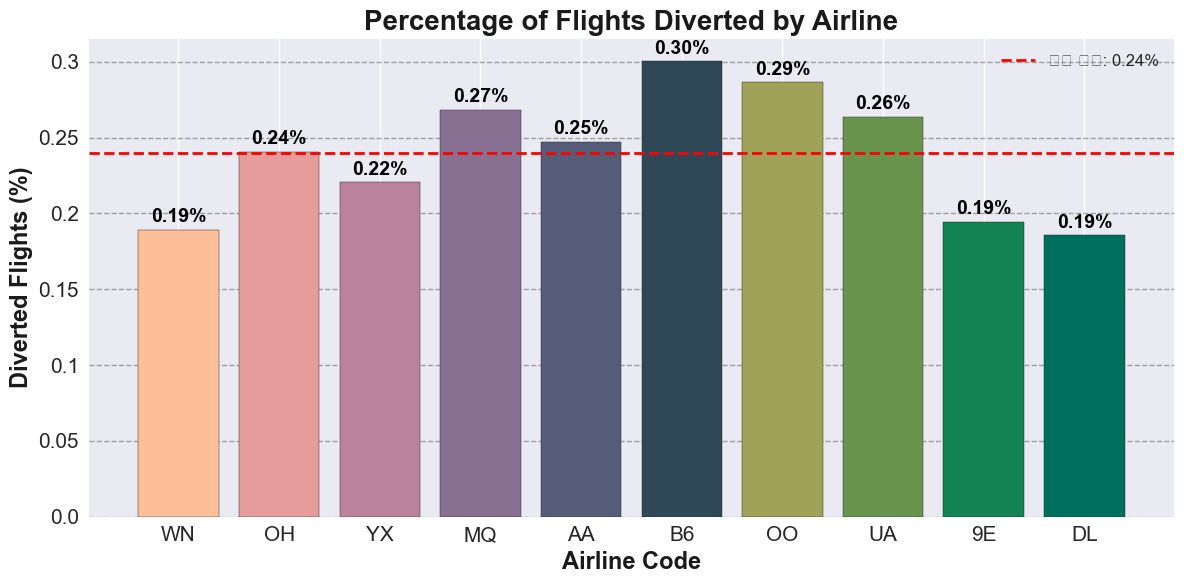

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# 항공사별 색상 할당
airline_colors = {
    'WN': '#febe98',  # 예시: WN 항공사에 #febe98 색상
    'OH': '#e59c9b',  # OH 항공사에 #e59c9b 색상
    'YX': '#ba839b',  # YX 항공사에 #ba839b 색상
    'MQ': '#877091',  # MQ 항공사에 #877091 색상
    'AA': '#555d79',  # AA 항공사에 #555d79 색상
    'B6': '#2f4858',  # B6 항공사에 #2f4858 색상
    'OO': '#a1a259',  # OO 항공사에 #a1a259 색상
    'UA': '#68944e',  # UA 항공사에 #68944e 색상
    '9E': '#148352',  # 9E 항공사에 #148352 색상
    'DL': '#00705e',  # DL 항공사에 #00705e 색상
}

# 전체 평균 이탈 비율 계산
overall_average = diverted_ratio_df['DIVERTED_PERCENTAGE'].mean()

# 항공사 순서 지정 (원하는 순서대로 항공사 코드를 리스트로 작성)
desired_airline_order = ['WN', 'OH', 'YX', 'MQ', 'AA', 'B6', 'OO', 'UA', '9E', 'DL']  # 예시: 원하는 항공사 순서

# 데이터를 desired_airline_order에 맞게 정렬
ordered_df = diverted_ratio_df.set_index('AIRLINE_CODE').loc[desired_airline_order]

# 막대 그래프의 x 위치 계산
x_pos = np.arange(len(ordered_df))

# figure 생성
fig, ax = plt.subplots(figsize=(12, 6))

# 막대 그래프 그리기 (barplot 대신 ax.bar 사용)
bars = ax.bar(
    x_pos,
    ordered_df['DIVERTED_PERCENTAGE'],
    color=[airline_colors[airline] for airline in ordered_df.index],
    width=0.8,
    edgecolor='k'
)

# 전체 평균 선 추가
ax.axhline(y=overall_average, color='red', linestyle='--', linewidth=2, label=f'전체 평균: {overall_average:.2f}%')

# 제목, 레이블, 범례 추가
ax.set_title("Percentage of Flights Diverted by Airline", fontsize=20, fontweight='bold', color='k')
ax.set_xlabel("Airline Code", fontsize=17, fontweight='bold', color='k')
ax.set_ylabel("Diverted Flights (%)", fontsize=17, fontweight='bold', color='k')
ax.set_xticks(x_pos)
ax.set_xticklabels(ordered_df.index, fontsize=15)

# y축 눈금 설정 (최대값을 0.31로 설정)
ax.set_yticks(np.arange(0, 0.32, 0.05))  # 0부터 0.31까지 0.05 간격으로 설정
ax.set_yticklabels(np.round(np.arange(0, 0.32, 0.05), 2), fontsize=15)

# 범례 추가
ax.legend(loc='upper right', fontsize=12)

# 그리드 추가
ax.grid(axis="y", linestyle="--", alpha=0.7, color='gray')

# 레이아웃 조정
plt.tight_layout()

# 각 값 명시 (위쪽에 값 표시)
for idx, value in enumerate(ordered_df['DIVERTED_PERCENTAGE']):
    ax.text(idx, value + 0.005, f"{value:.2f}%", ha="center", fontsize=14, color='black', fontweight='bold')

# 그래프 출력
plt.show()

## 예정된 비행 시간과 실제 비행 시간 차이

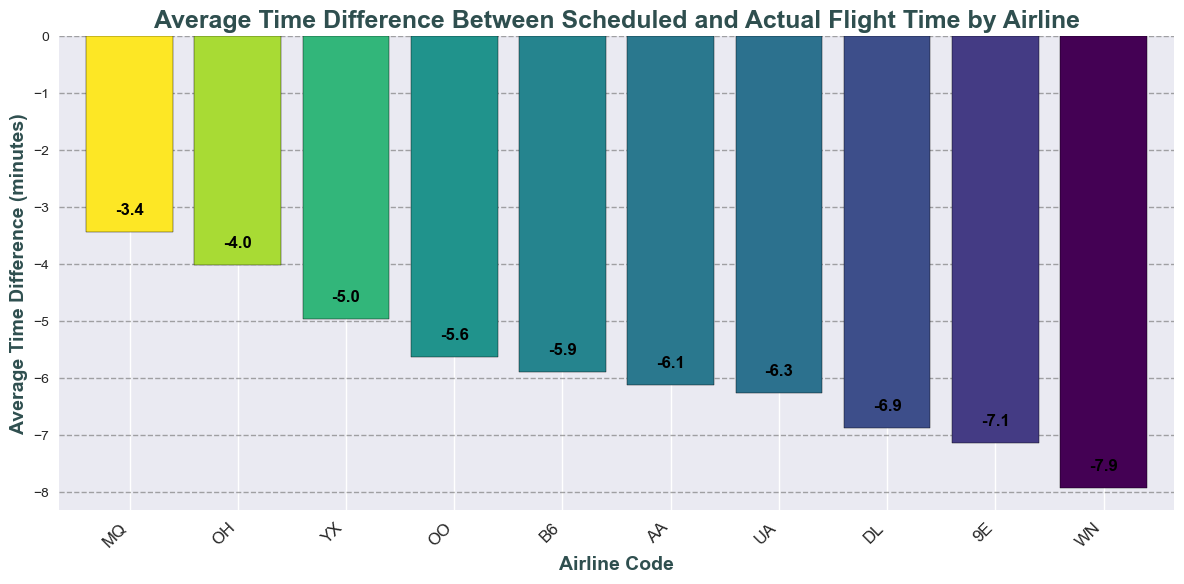

In [52]:
# Step 1: 각 항공사별로 예정된 비행 시간과 실제 비행 시간의 차이 계산
df['TIME_DIFF'] = df['ELAPSED_TIME'] - df['CRS_ELAPSED_TIME']

# Step 2: 항공사별 평균 차이 계산
avg_time_diff = df.groupby('AIRLINE_CODE')['TIME_DIFF'].mean()

# Step 3: 데이터 정렬 (차이가 큰 항공사부터 정렬)
avg_time_diff = avg_time_diff.sort_values(ascending=False)

# Step 4: 시각화
plt.figure(figsize=(12, 6))  # 그래프 크기 설정

# 색상 그라데이션으로 바 차트 시각화 (차이값에 따라 색상 조정)
colors = plt.cm.viridis((avg_time_diff - avg_time_diff.min()) / (avg_time_diff.max() - avg_time_diff.min()))  # 'plasma' 컬러맵 사용

# 바 차트로 시각화 (차이 값 시각화)
ax = avg_time_diff.plot(kind='bar', color=colors, edgecolor='black', width=0.8)

# 그래프 제목 및 축 레이블
plt.title("Average Time Difference Between Scheduled and Actual Flight Time by Airline", fontsize=18, fontweight='bold', color='darkslategray')
plt.xlabel("Airline Code", fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel("Average Time Difference (minutes)", fontsize=14, fontweight='bold', color='darkslategray')
plt.xticks(rotation=45, ha="right", fontsize=12)

# 각 값 명시 (위쪽에 값 표시)
for idx, value in enumerate(avg_time_diff):
    ax.text(idx, value + 0.3, f"{value:.1f}", ha="center", fontsize=12, color='black', fontweight='bold')

# 그리드 추가 및 레이아웃 조정
plt.grid(axis="y", linestyle="--", alpha=0.7, color='gray')
plt.tight_layout()

# 그래프 출력
plt.show()

## 우회, 취소, 지연이 높은 시기에 제시간에 비행했는지

/var/folders/qt/6zfp3p4j4v10mzbh5ffczxv00000gn/T/ipykernel_36866/4170757721.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


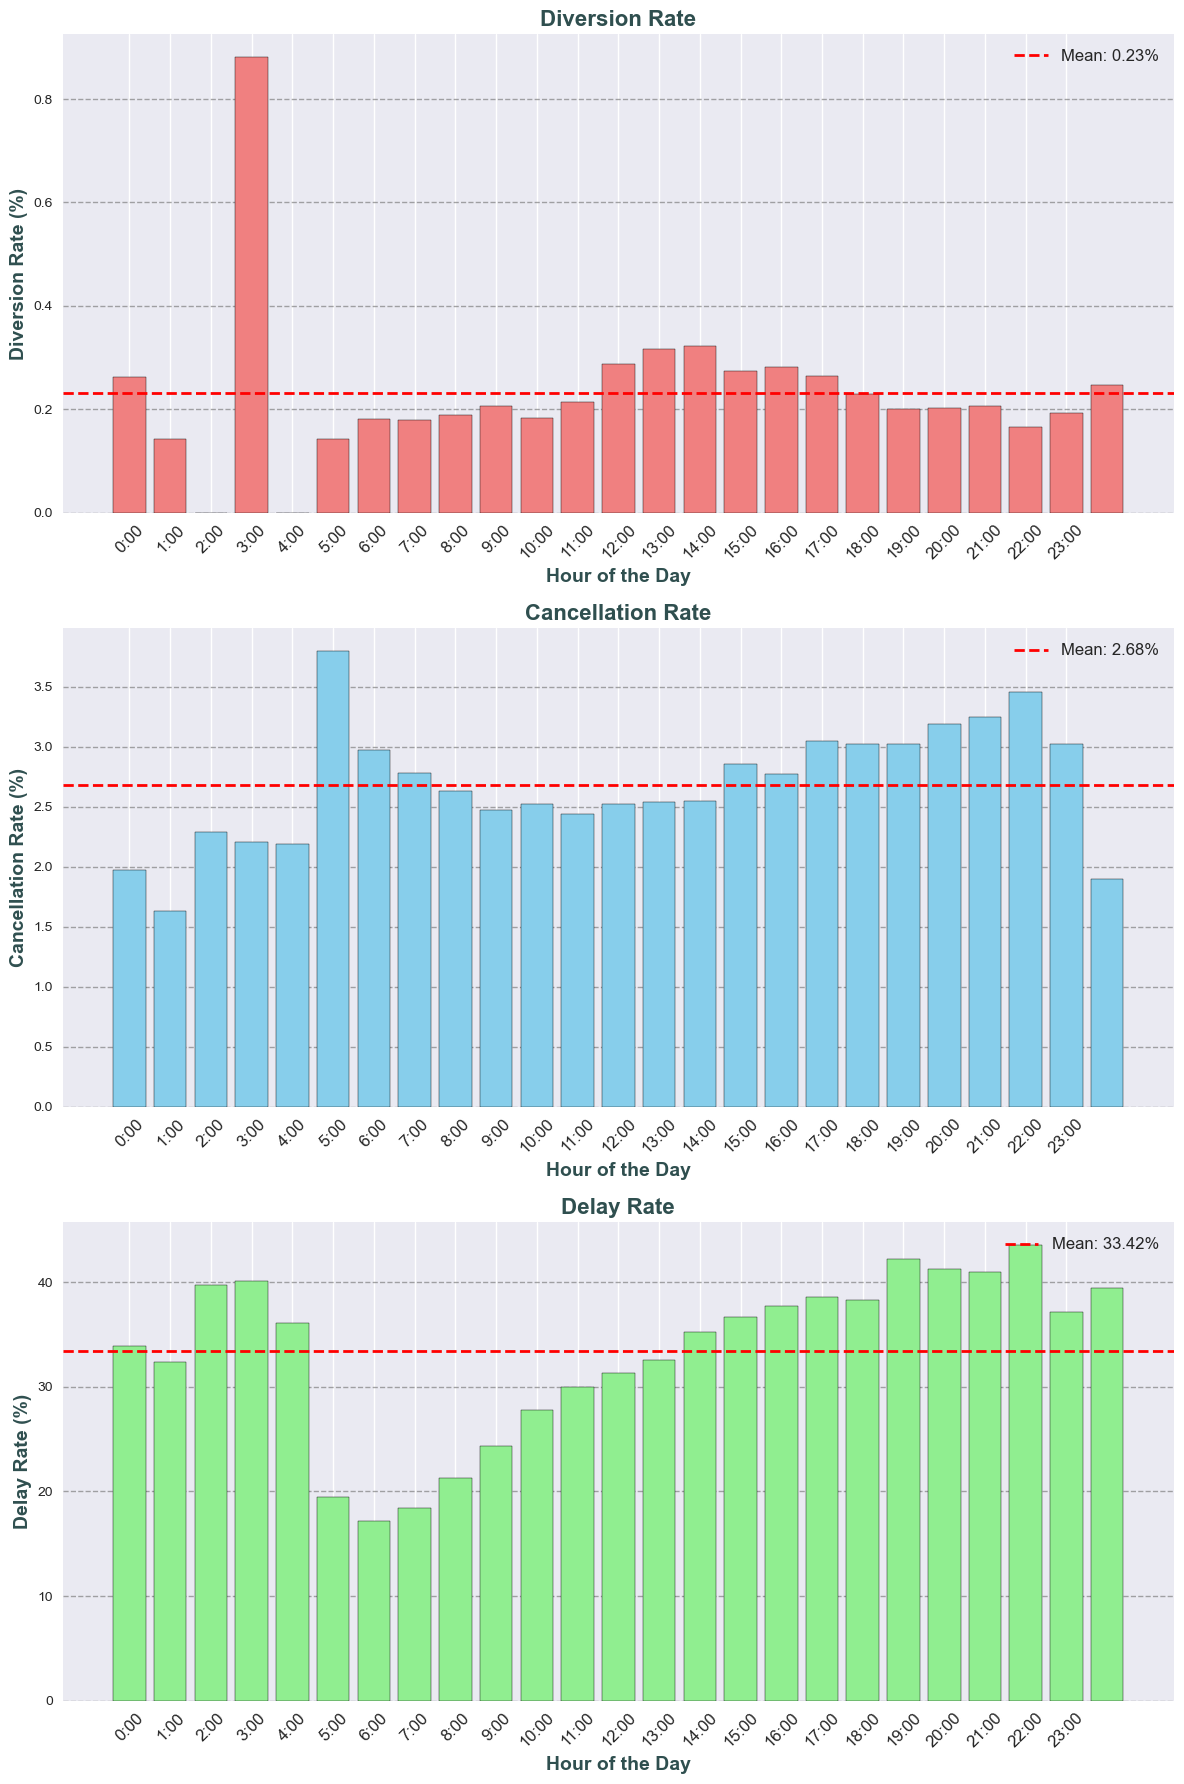

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# CRS_DEP_TIME에서 시간과 분 추출
df["DEP_HOUR"] = df["CRS_DEP_TIME"] // 100  # 시간 부분
df["DEP_MINUTE"] = df["CRS_DEP_TIME"] % 100  # 분 부분

# 30분 단위로 반올림 (30분 이상은 1시간 증가)
df["DEP_HOUR_ROUNDED"] = np.where(df["DEP_MINUTE"] >= 30, df["DEP_HOUR"] + 1, df["DEP_HOUR"])

# 시간대별 우회율 계산
diverted_rate_hour = df.groupby("DEP_HOUR_ROUNDED")["DIVERTED"].mean() * 100

# 시간대별 취소율 계산
cancellation_rate_hour = (df.groupby("DEP_HOUR_ROUNDED")["CANCELLED"].mean()) * 100

# 시간대별 지연율 계산
delayed_rate_hour = (df.groupby("DEP_HOUR_ROUNDED")["DEP_DELAY"].apply(lambda x: (x > 0).mean())) * 100

# 각 그래프를 개선된 디자인으로 시각화

def plot_graph(data, title, ylabel, color, ax):
    # 그래프 그리기
    ax.bar(data.index, data, color=color, edgecolor='black', width=0.8)
    
    # 평균선 추가
    mean_value = data.mean()
    ax.axhline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}%')
    
    # 그래프 제목 및 축 레이블
    ax.set_title(title, fontsize=16, fontweight='bold', color='darkslategray')
    ax.set_xlabel("Hour of the Day", fontsize=14, fontweight='bold', color='darkslategray')
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold', color='darkslategray')
    
    # x축 레이블 스타일
    ax.set_xticks(range(24))
    ax.set_xticklabels([f"{i}:00" for i in range(24)], rotation=45, fontsize=12)
    
    # y축 그리드 추가
    ax.grid(axis="y", linestyle="--", alpha=0.7, color='gray')
    
    # 레이아웃 조정
    ax.legend(loc='upper right', fontsize=12)
    plt.tight_layout()

# Subplot 설정
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# 우회율 그래프
plot_graph(diverted_rate_hour, "Diversion Rate", "Diversion Rate (%)", "lightcoral", axs[0])

# 취소율 그래프
plot_graph(cancellation_rate_hour, "Cancellation Rate", "Cancellation Rate (%)", "skyblue", axs[1])

# 지연율 그래프
plot_graph(delayed_rate_hour, "Delay Rate", "Delay Rate (%)", "lightgreen", axs[2])

# 그래프 출력
plt.show()

AIRLINE_CODE
9E    0.205659
AA    0.336942
B6    0.393679
DL    0.234121
MQ    0.291232
OH    0.290057
OO    0.279442
UA    0.348142
WN    0.247067
YX    0.277605
Name: DIVERTED, dtype: float64


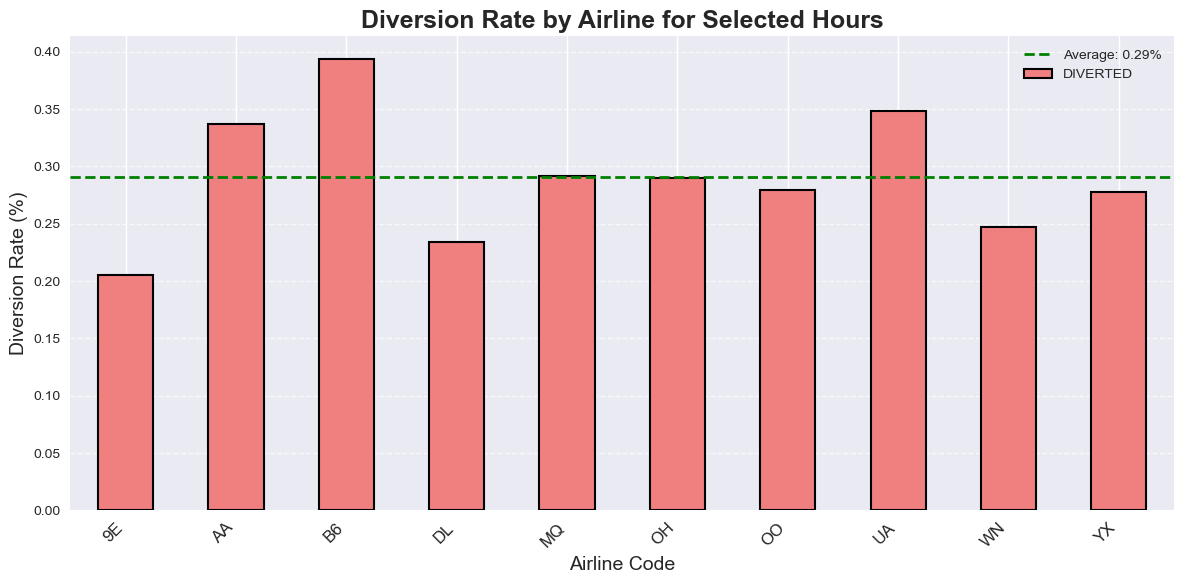

In [54]:
# 필터링할 시간 리스트
hours_to_filter = [0, 3, 12, 13, 14, 15, 16, 17, 18]

# 해당 시간대의 데이터만 필터링
df_filtered = df[df["DEP_HOUR_ROUNDED"].isin(hours_to_filter)]

# 항공사별 우회율 계산 (해당 시간대의 데이터 기준)
diverted_rate_by_airline_filtered = df_filtered.groupby("AIRLINE_CODE")["DIVERTED"].mean() * 100

# 시리즈 출력 (값이 시리즈로 나타남)
print(diverted_rate_by_airline_filtered)

# 시각화
plt.figure(figsize=(12, 6))

# 막대 그래프 스타일 및 색상 설정
ax = diverted_rate_by_airline_filtered.plot(kind="bar", color="lightcoral", edgecolor="black", linewidth=1.5)

# 평균값 표시
mean_value = diverted_rate_by_airline_filtered.mean()
plt.axhline(mean_value, color="green", linestyle="--", linewidth=2, label=f"Average: {mean_value:.2f}%")

# 그래프 제목 및 축 레이블 설정
plt.title("Diversion Rate by Airline for Selected Hours", fontsize=18, fontweight='bold')
plt.xlabel("Airline Code", fontsize=14)
plt.ylabel("Diversion Rate (%)", fontsize=14)

# x축 레이블 회전 및 간격 조정
plt.xticks(rotation=45, ha="right", fontsize=12)

# y축에 그리드 추가
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 평균값 레이블 추가
plt.legend(loc="upper right")

# 레이아웃 자동 조정
plt.tight_layout()

# 그래프 출력
plt.show()

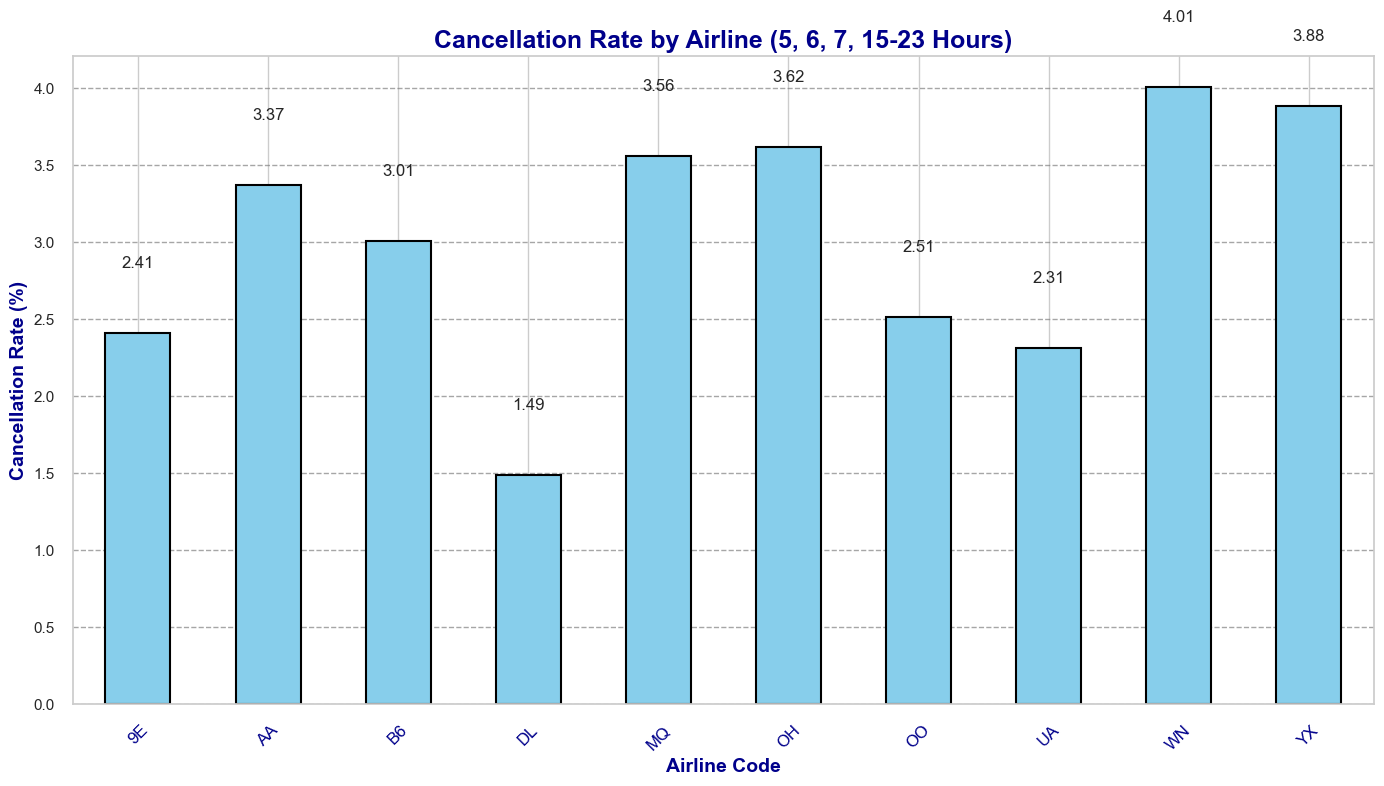

In [55]:
# 5, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 23시 데이터 필터링
df_filtered = df[df["DEP_HOUR_ROUNDED"].isin([5, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 23])]

# 각 항공사별 취소율 계산
cancellation_rate_airline = df_filtered.groupby("AIRLINE_CODE")["CANCELLED"].mean() * 100

# 시각화
plt.figure(figsize=(14, 8))  # 크기를 적절히 조정
sns.set(style="whitegrid")  # 배경을 흰색 그리드로 설정

# 바 그래프 그리기
ax = cancellation_rate_airline.plot(kind="bar", color="skyblue", edgecolor="black", linewidth=1.5)

# 그래프 제목 및 축 레이블
plt.title("Cancellation Rate by Airline (5, 6, 7, 15-23 Hours)", fontsize=18, weight='bold', color='darkblue')
plt.xlabel("Airline Code", fontsize=14, weight='bold', color='darkblue')
plt.ylabel("Cancellation Rate (%)", fontsize=14, weight='bold', color='darkblue')

# x축 레이블 회전 및 스타일 설정
plt.xticks(rotation=45, fontsize=12, color='darkblue')

# 각 막대 위에 값 표시 (조정된 y 위치)
for i, v in enumerate(cancellation_rate_airline):
    ax.text(i, v + 0.5, f"{v:.2f}", ha='center', va='top', fontsize=12)

# 그리드 추가 및 스타일
plt.grid(axis="y", linestyle="--", alpha=0.7, color="gray")
plt.tight_layout()  # 레이아웃 조정

# 그래프 출력
plt.show()

In [56]:
# 'SEASON' 열이 없을 경우 생성 (예: 날짜 데이터를 이용해 시즌 정의)
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"

df['MONTH'] = pd.to_datetime(df['FL_DATE'], format='%Y-%m-%d').dt.month
df['SEASON'] = df['MONTH'].apply(get_season)

# 시즌별 우회율, 취소율, 지연율 계산
diverted_rate_season = df.groupby('SEASON')['DIVERTED'].mean() * 100
cancellation_rate_season = df.groupby('SEASON')['CANCELLED'].mean() * 100
delayed_rate_season = (df[df['DEP_DELAY'] > 0].groupby('SEASON').size() / df.groupby('SEASON').size()) * 100

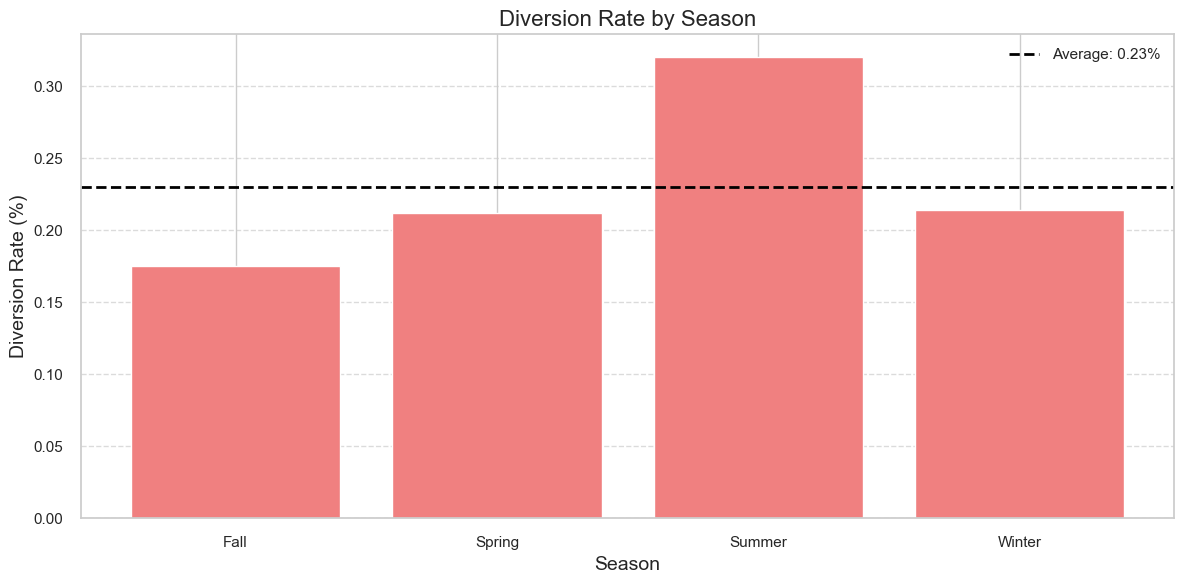

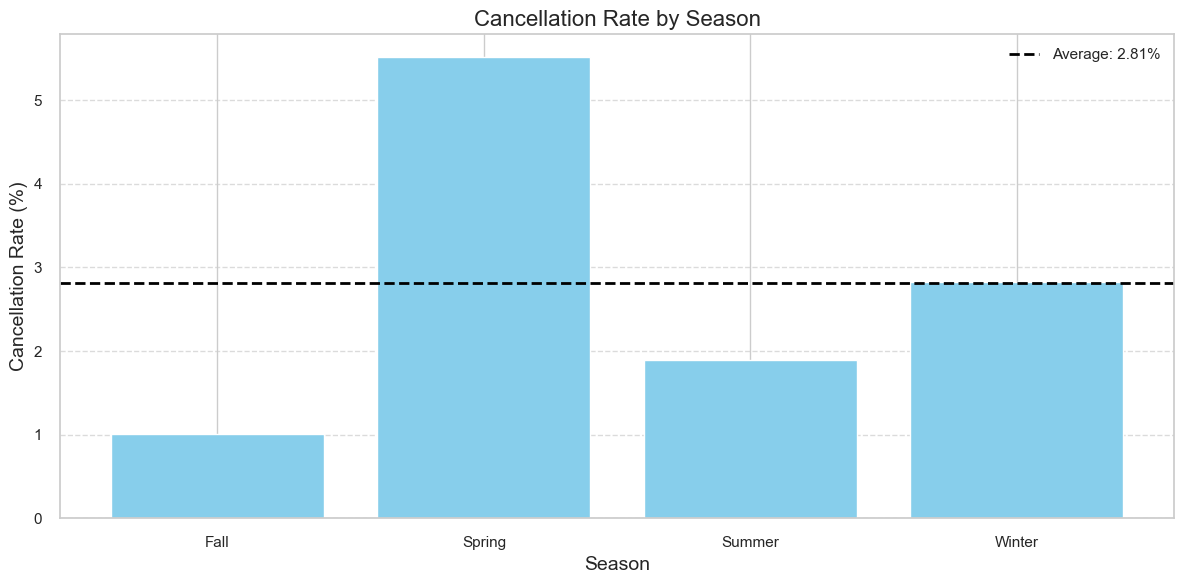

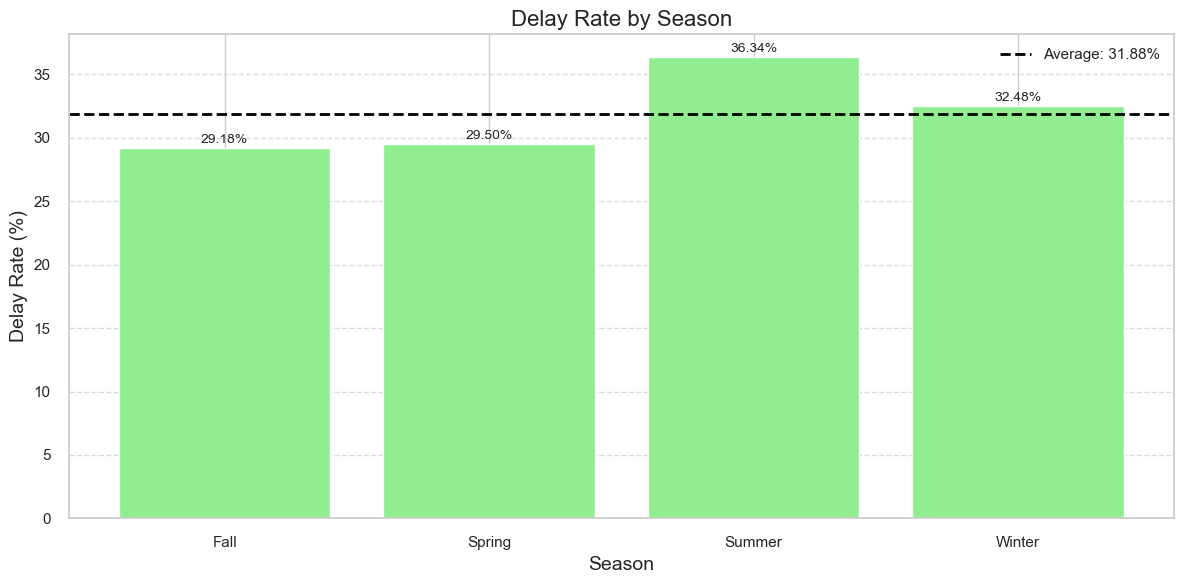

In [57]:
# 우회율 그래프
plt.figure(figsize=(12, 6))
ax = plt.gca()  # 현재 Axes 객체 가져오기
bars = ax.bar(diverted_rate_season.index, diverted_rate_season, color="lightcoral")
plt.title("Diversion Rate by Season", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Diversion Rate (%)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 평균 선 추가
avg_diverted_rate = diverted_rate_season.mean()
plt.axhline(avg_diverted_rate, color="black", linestyle="--", linewidth=2, label=f"Average: {avg_diverted_rate:.2f}%")

# 범례 추가
plt.legend()

plt.tight_layout()
plt.show()

# 취소율 그래프
plt.figure(figsize=(12, 6))
ax = plt.gca()  # 현재 Axes 객체 가져오기
bars = ax.bar(cancellation_rate_season.index, cancellation_rate_season, color="skyblue")
plt.title("Cancellation Rate by Season", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Cancellation Rate (%)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 평균 선 추가
avg_cancellation_rate = cancellation_rate_season.mean()
plt.axhline(avg_cancellation_rate, color="black", linestyle="--", linewidth=2, label=f"Average: {avg_cancellation_rate:.2f}%")

# 범례 추가
plt.legend()

plt.tight_layout()
plt.show()

# 지연율 그래프
plt.figure(figsize=(12, 6))
ax = plt.gca()  # 현재 Axes 객체 가져오기
bars = ax.bar(delayed_rate_season.index, delayed_rate_season, color="lightgreen")
plt.title("Delay Rate by Season", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Delay Rate (%)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 평균 선 추가
avg_delayed_rate = delayed_rate_season.mean()
plt.axhline(avg_delayed_rate, color="black", linestyle="--", linewidth=2, label=f"Average: {avg_delayed_rate:.2f}%")

# 각 막대 위에 값 추가
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, f"{yval:.2f}%", ha='center', va='bottom', fontsize=10)

# 범례 추가
plt.legend()

plt.tight_layout()
plt.show()

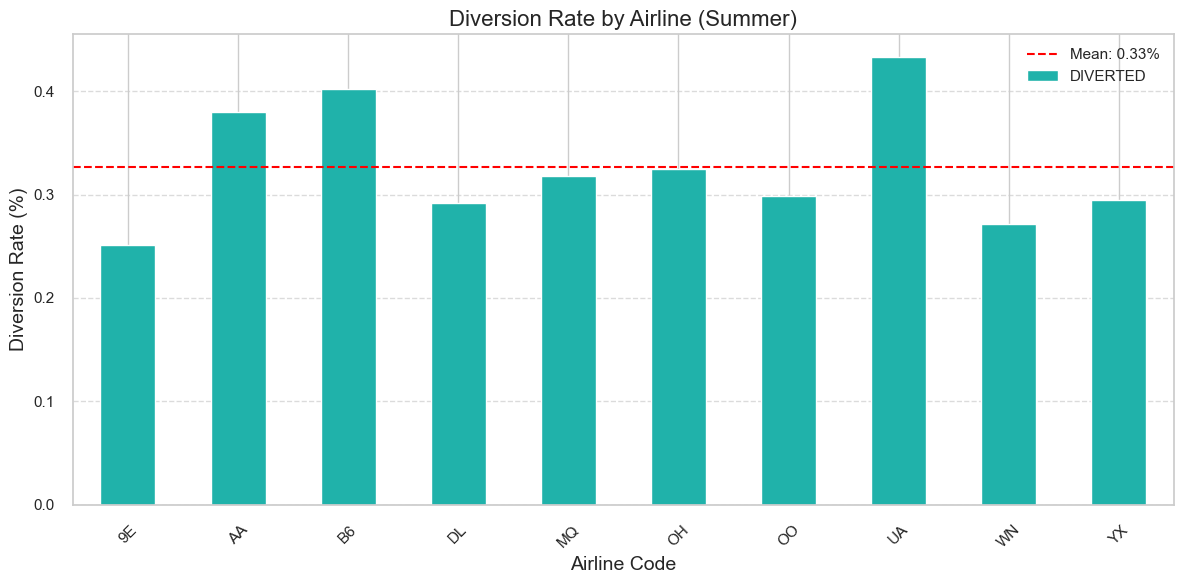

In [58]:
# FL_DATE 열을 datetime 형식으로 변환
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"], format="%Y-%m-%d")

# 여름 데이터 필터링 (여름: 6, 7, 8월)
summer_data = df[df["FL_DATE"].dt.month.isin([6, 7, 8])]

# 각 항공사별 우회율 계산 (우회는 DIVERTED 컬럼이 1인 경우)
diversion_rate_airline = summer_data.groupby("AIRLINE_CODE")["DIVERTED"].mean() * 100

# 평균 우회율 계산
mean_diversion_rate = diversion_rate_airline.mean()

# 시각화
plt.figure(figsize=(12, 6))
ax = diversion_rate_airline.plot(kind="bar", color="lightseagreen")
plt.title("Diversion Rate by Airline (Summer)", fontsize=16)
plt.xlabel("Airline Code", fontsize=14)
plt.ylabel("Diversion Rate (%)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 평균 우회율에 수평선 그리기
ax.axhline(mean_diversion_rate, color="red", linestyle="--", label=f"Mean: {mean_diversion_rate:.2f}%")

# 범례 추가
plt.legend()

plt.tight_layout()
plt.show()

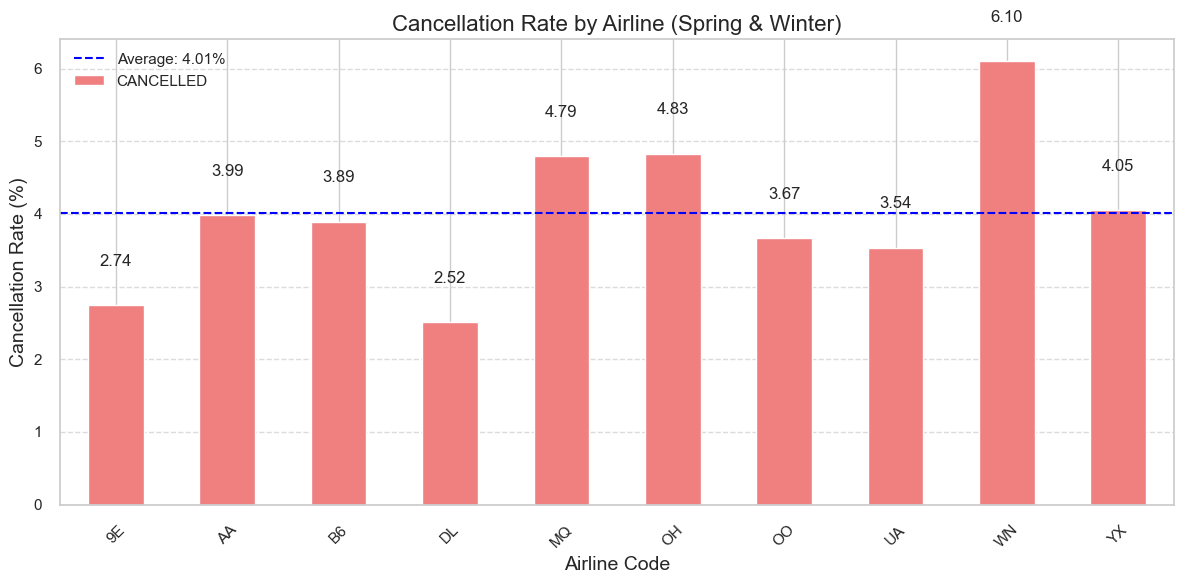

In [59]:
# 봄과 겨울 데이터 필터링
season_data = df[df["FL_DATE"].dt.month.isin([3, 4, 5, 12, 1, 2])]

# 각 항공사별 취소율 계산
cancellation_rate_airline = season_data.groupby("AIRLINE_CODE")["CANCELLED"].mean() * 100

# 평균값 계산
avg_cancellation_rate = cancellation_rate_airline.mean()

# 시각화
plt.figure(figsize=(12, 6))
ax = cancellation_rate_airline.plot(kind="bar", color="lightcoral")
plt.title("Cancellation Rate by Airline (Spring & Winter)", fontsize=16)
plt.xlabel("Airline Code", fontsize=14)
plt.ylabel("Cancellation Rate (%)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 평균값에 줄 추가
plt.axhline(avg_cancellation_rate, color="blue", linestyle="--", label=f"Average: {avg_cancellation_rate:.2f}%")

# 각 막대 위에 값 표시
for i, v in enumerate(cancellation_rate_airline):
    ax.text(i, v + 0.5, f"{v:.2f}", ha='center', va='bottom', fontsize=12)

# 범례 추가
plt.legend()

plt.tight_layout()
plt.show()

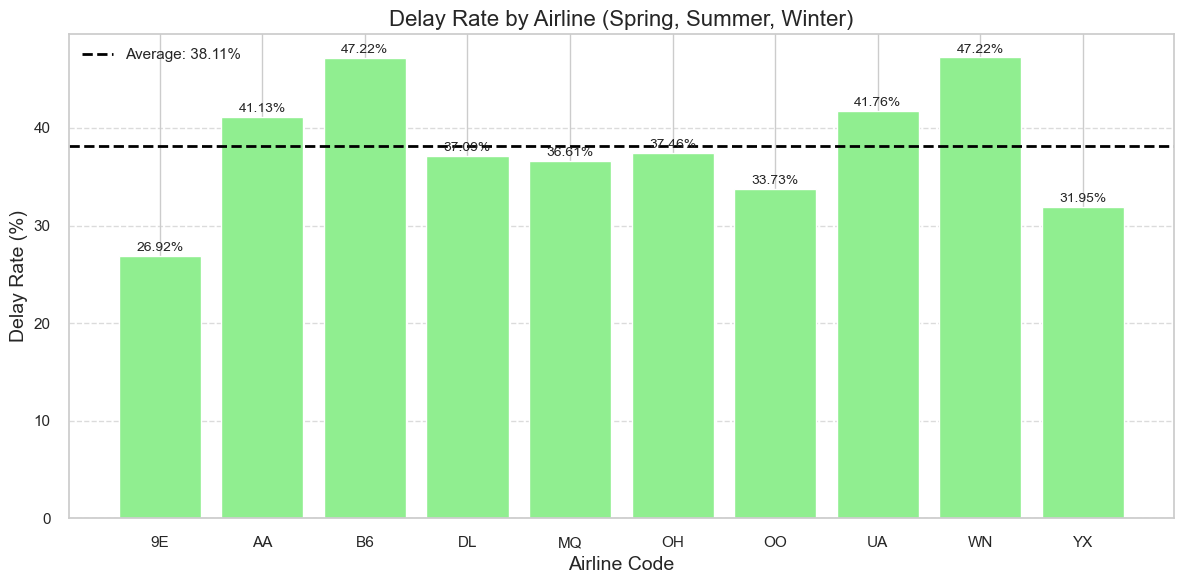

In [60]:
# 각 항공사별 지연률 계산 (출발 지연 + 도착 지연)
delayed_rate_airline_season = season_data.groupby("AIRLINE_CODE").apply(
    lambda x: ((x["DEP_DELAY"] > 0) | (x["ARR_DELAY"] > 0)).mean() * 100
)

# 평균값 계산
avg_delayed_rate = delayed_rate_airline_season.mean()

# 시각화
plt.figure(figsize=(12, 6))
ax = plt.gca()  # 현재 Axes 객체 가져오기
bars = ax.bar(delayed_rate_airline_season.index, delayed_rate_airline_season, color="lightgreen")
plt.title("Delay Rate by Airline (Spring, Summer, Winter)", fontsize=16)
plt.xlabel("Airline Code", fontsize=14)
plt.ylabel("Delay Rate (%)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 평균 선 추가
plt.axhline(avg_delayed_rate, color="black", linestyle="--", linewidth=2, label=f"Average: {avg_delayed_rate:.2f}%")

# 각 막대 위에 값 추가
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, f"{yval:.2f}%", ha='center', va='bottom', fontsize=10)

# 범례 추가
plt.legend()

plt.tight_layout()
plt.show()

## 점수 계산

### 출발/도착 지연 시간에 따른 점수

In [61]:
# Total Delay 기준으로 점수 계산
min_delay = airline_delay['TOTAL_DELAY'].min()
max_delay = airline_delay['TOTAL_DELAY'].max()

# 점수 계산 공식
airline_delay['Score'] = 70 + (30 * (max_delay - airline_delay['TOTAL_DELAY']) / (max_delay - min_delay))

# 점수 기준으로 내림차순 정렬
airline_delay_sorted = airline_delay.sort_values(by='Score', ascending=False)

# 결과 확인
print(airline_delay_sorted[['AIRLINE_CODE', 'TOTAL_DELAY', 'Score']])

  AIRLINE_CODE  TOTAL_DELAY       Score
0           9E     3.886626  100.000000
9           YX     6.800436   96.309668
3           DL     7.002174   96.054168
4           MQ     9.572429   92.798947
5           OH    11.669320   90.143241
8           WN    12.765301   88.755185
6           OO    13.248523   88.143185
7           UA    13.777067   87.473786
1           AA    15.753193   84.971029
2           B6    27.574010   70.000000


### 출발 시간이 지연됐을 때 도착 지연에 따른 점수

In [62]:
# 출발 지연 시간 - 도착 지연 시간 계산
airline_delay['DEP_ARR_DELAY_DIFF'] = airline_delay['DEP_DELAY'] - airline_delay['ARR_DELAY']

# 출발 지연 - 도착 지연 시간 차이의 최소값과 최대값 계산
min_diff = airline_delay['DEP_ARR_DELAY_DIFF'].min()
max_diff = airline_delay['DEP_ARR_DELAY_DIFF'].max()

# 점수 계산 공식: 점수 = 70 + (30 * (최대 차이 - 해당 차이) / (최대 차이 - 최소 차이))
airline_delay['Score'] = 70 + (30 * (max_diff - airline_delay['DEP_ARR_DELAY_DIFF']) / (max_diff - min_diff))

# 점수 기준으로 내림차순 정렬
airline_delay_sorted = airline_delay.sort_values(by='Score', ascending=False)

# 결과 확인
print(airline_delay_sorted[['AIRLINE_CODE', 'DEP_ARR_DELAY_DIFF', 'Score']])

  AIRLINE_CODE  DEP_ARR_DELAY_DIFF       Score
4           MQ            3.533626  100.000000
5           OH            4.093073   96.201883
9           YX            5.088300   89.445226
6           OO            5.681869   85.415454
2           B6            6.060361   82.845844
1           AA            6.196385   81.922371
7           UA            6.315741   81.112056
3           DL            6.942627   76.856093
0           9E            7.186794   75.198429
8           WN            7.952501   70.000000


In [63]:
# 택시 아웃과 택시 인 시간을 합쳐서 총 택시 시간 계산
taxi_times_by_airline['TOTAL_TAXI_TIME'] = taxi_times_by_airline['TAXI_OUT'] + taxi_times_by_airline['TAXI_IN']

# 총 택시 시간의 최소값과 최대값 계산
min_total_taxi_time = taxi_times_by_airline['TOTAL_TAXI_TIME'].min()
max_total_taxi_time = taxi_times_by_airline['TOTAL_TAXI_TIME'].max()

# 총 택시 시간에 대한 점수 계산 (가장 작은 값에는 100점, 가장 큰 값에는 70점)
taxi_times_by_airline['Total_Taxi_Score'] = 70 + (30 * (max_total_taxi_time - taxi_times_by_airline['TOTAL_TAXI_TIME']) / (max_total_taxi_time - min_total_taxi_time))

# 총 택시 점수 기준으로 내림차순 정렬
taxi_times_by_airline_sorted = taxi_times_by_airline.sort_values(by='Total_Taxi_Score', ascending=False)

# 결과 확인
print(taxi_times_by_airline_sorted[['AIRLINE_CODE', 'TOTAL_TAXI_TIME', 'Total_Taxi_Score']])

  AIRLINE_CODE  TOTAL_TAXI_TIME  Total_Taxi_Score
8           WN        17.490315        100.000000
3           DL        23.563268         83.819198
0           9E        25.046542         79.867158
6           OO        25.232814         79.370854
2           B6        25.525236         78.591722
7           UA        26.562708         75.827477
1           AA        26.593238         75.746133
4           MQ        26.690962         75.485757
5           OH        28.126029         71.662160
9           YX        28.749868         70.000000


### 100 - 취소율

In [64]:
# 완료율을 점수로 그대로 사용
completion_rate_score = completion_rate.sort_values(ascending=False)

# 결과를 시리즈로 출력
print(completion_rate_score)

AIRLINE_CODE
DL    98.477332
9E    97.922596
UA    97.753708
OO    97.651496
B6    97.275865
AA    96.877557
MQ    96.765752
YX    96.762440
OH    96.731998
WN    96.207966
Name: CANCELLED, dtype: float64


### 100 - 우회율

In [65]:
# Step 1: Calculate the diverted percentage by airline
diverted_ratio = df.groupby('AIRLINE_CODE')['DIVERTED'].mean() * 100

# Step 2: Convert Series to DataFrame and rename columns
diverted_ratio_df = diverted_ratio.reset_index()
diverted_ratio_df.columns = ['AIRLINE_CODE', 'DIVERTED_PERCENTAGE']

# Step 3: Find the maximum and minimum diverted percentage
max_diverted = diverted_ratio_df['DIVERTED_PERCENTAGE'].max()
min_diverted = diverted_ratio_df['DIVERTED_PERCENTAGE'].min()

# Step 4: Calculate the score based on min-max scaling
diverted_ratio_df['DIVERTED_SCORE'] = 70 + (30 * (max_diverted - diverted_ratio_df['DIVERTED_PERCENTAGE']) / (max_diverted - min_diverted))

# Step 5: Sort the data by the score
diverted_ratio_df_sorted = diverted_ratio_df.sort_values(by='DIVERTED_SCORE', ascending=False)

# Step 6: Print the result as a Series
print(diverted_ratio_df_sorted[['AIRLINE_CODE', 'DIVERTED_SCORE']])

  AIRLINE_CODE  DIVERTED_SCORE
3           DL      100.000000
8           WN       99.033529
0           9E       97.673031
9           YX       90.847560
5           OH       85.576981
1           AA       83.846732
7           UA       79.535240
4           MQ       78.377902
6           OO       73.646139
2           B6       70.000000


### 비행 시간 정확도

In [66]:
# Step 1: 각 항공사별로 예정된 비행 시간과 실제 비행 시간의 차이 계산
df['TIME_DIFF'] = df['ELAPSED_TIME'] - df['CRS_ELAPSED_TIME']

# Step 2: 항공사별 평균 차이 계산
avg_time_diff = df.groupby('AIRLINE_CODE')['TIME_DIFF'].mean()

# Step 3: 데이터 정렬 (차이가 큰 항공사부터 정렬)
avg_time_diff = avg_time_diff.sort_values(ascending=False)

# Step 4: Min-Max Scaling으로 점수 매기기
max_time_diff = avg_time_diff.max()
min_time_diff = avg_time_diff.min()

# 계산된 점수 (최대값은 100점, 최소값은 70점)
avg_time_diff_score = 70 + (30 * (max_time_diff - avg_time_diff) / (max_time_diff - min_time_diff))

# Step 5: 결과 출력 (점수 포함)
avg_time_diff_score_sorted = avg_time_diff_score.sort_values(ascending=False)

# Step 6: 출력
print(avg_time_diff_score_sorted)

AIRLINE_CODE
WN    100.000000
9E     94.726830
DL     92.938990
UA     88.827659
AA     87.958872
B6     86.465349
OO     84.620687
YX     80.245094
OH     73.886513
MQ     70.000000
Name: TIME_DIFF, dtype: float64


## 평균적으로 우회, 취소, 지연이 높은 시간, 날짜에 잘 비행한 항공사에 가산점
### 우회율

In [67]:
# 평균보다 낮은 항공사 필터링
below_average = diverted_rate_by_airline_filtered[diverted_rate_by_airline_filtered < mean_value]

# Min-Max Scaling 점수 계산
min_value = below_average.min()
max_value = mean_value
scaled_scores = 50 * (1 - (below_average - min_value) / (max_value - min_value))

# 시리즈 반환
scaled_scores.name = "Score"
print(scaled_scores)

AIRLINE_CODE
9E    50.000000
DL    33.205425
OH     0.199328
OO     6.462657
WN    25.566130
YX     7.546615
Name: Score, dtype: float64


### 취소율

In [68]:
# 5, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 23시 데이터 필터링
df_filtered = df[df["DEP_HOUR_ROUNDED"].isin([5, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 23])]

# 각 항공사별 취소율 계산
cancellation_rate_airline = df_filtered.groupby("AIRLINE_CODE")["CANCELLED"].mean() * 100

# 평균 및 최소 취소율 계산
average_rate = cancellation_rate_airline.mean()
min_rate = cancellation_rate_airline.min()

# 평균보다 낮은 값만 필터링
filtered_rates = cancellation_rate_airline[cancellation_rate_airline < average_rate]

# Min-Max Scaling을 통해 점수 계산
scaled_scores = 50 * (average_rate - filtered_rates) / (average_rate - min_rate)

# 점수를 내림차순으로 정렬
sorted_scores = scaled_scores.sort_values(ascending=False)

# 정렬된 점수 시리즈 반환
sorted_scores

AIRLINE_CODE
DL    50.000000
UA    23.108038
9E    19.925381
OO    16.445738
B6     0.391918
Name: CANCELLED, dtype: float64

In [69]:
# 2~4시, 14~23시 데이터 필터링
df_filtered = df[df["DEP_HOUR_ROUNDED"].isin([2, 3, 4]) | df["DEP_HOUR_ROUNDED"].between(14, 23)]

# 각 항공사별 지연율 계산 (지연 시간 > 0)
delay_rate_airline = df_filtered.groupby("AIRLINE_CODE")["DEP_DELAY"].apply(lambda x: (x > 0).mean()) * 100

# 평균 및 최소 지연율 계산
average_delay_rate = delay_rate_airline.mean()
min_delay_rate = delay_rate_airline.min()

# 평균보다 낮은 값만 필터링
filtered_delay_rates = delay_rate_airline[delay_rate_airline < average_delay_rate]

# Min-Max Scaling을 통해 점수 계산
scaled_scores = 50 * (average_delay_rate - filtered_delay_rates) / (average_delay_rate - min_delay_rate)

# 점수를 내림차순으로 정렬
sorted_scores = scaled_scores.sort_values(ascending=False)

# 정렬된 점수 시리즈 반환
sorted_scores

AIRLINE_CODE
9E    50.000000
YX    36.456740
OO    30.680379
MQ    21.866127
OH    12.535807
DL     5.670222
Name: DEP_DELAY, dtype: float64

## 계절별
### 우회율

In [70]:
# FL_DATE 열을 datetime 형식으로 변환
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"], format="%Y-%m-%d")

# 여름 데이터 필터링 (여름: 6, 7, 8월)
summer_data = df[df["FL_DATE"].dt.month.isin([6, 7, 8])]

# 각 항공사별 우회율 계산 (우회는 DIVERTED 컬럼이 1인 경우)
diversion_rate_airline = summer_data.groupby("AIRLINE_CODE")["DIVERTED"].mean() * 100

# 평균 우회율 계산
mean_diversion_rate = diversion_rate_airline.mean()

# 평균보다 작은 값에만 점수 부여
diversion_rate_below_avg = diversion_rate_airline[diversion_rate_airline < mean_diversion_rate]

# min-max scaling을 통한 점수 부여 (가장 작은 값에 50점, 평균 0점 기준)
min_diversion_rate = diversion_rate_below_avg.min()
max_diversion_rate = diversion_rate_below_avg.max()

# 점수 계산: (최댓값 - 우회율) / (최댓값 - 최솟값) * 50
# 가장 작은 값에는 50점, 그 외 값은 비율에 맞게 점수를 부여
scores = (max_diversion_rate - diversion_rate_below_avg) / (max_diversion_rate - min_diversion_rate) * 50

# 점수 내림차순으로 정렬
sorted_scores = scores.sort_values(ascending=False)

# 시리즈 반환
sorted_scores

AIRLINE_CODE
9E    50.000000
WN    36.516655
DL    22.490519
YX    20.711948
OO    17.541552
MQ     4.125501
OH     0.000000
Name: DIVERTED, dtype: float64

### 취소율

In [71]:
# 봄과 겨울 데이터 필터링
season_data = df[df["FL_DATE"].dt.month.isin([3, 4, 5, 12, 1, 2])]

# 각 항공사별 취소율 계산
cancellation_rate_airline = season_data.groupby("AIRLINE_CODE")["CANCELLED"].mean() * 100

# 평균값 계산
avg_cancellation_rate = cancellation_rate_airline.mean()

# 평균보다 작은 값만 필터링
below_avg_cancellation_rate = cancellation_rate_airline[cancellation_rate_airline < avg_cancellation_rate]

# 가장 작은 값 찾기
min_value = below_avg_cancellation_rate.min()

# min-max scaling: 가장 작은 값에 50점, 평균값에 0점
# 점수 계산 공식 수정: 최소값을 50점으로 설정하고, 그에 맞게 스케일링
scaled_scores = (avg_cancellation_rate - below_avg_cancellation_rate) / (avg_cancellation_rate - min_value) * 50

# 점수 내림차순으로 정렬
scaled_scores = scaled_scores.sort_values(ascending=False)

# 결과 반환
scaled_scores

AIRLINE_CODE
DL    50.000000
9E    42.385026
UA    15.843387
OO    11.494816
B6     3.969512
AA     0.869097
Name: CANCELLED, dtype: float64

In [72]:
# 1. 가장 작은 값과 가장 큰 값 계산
min_value = delayed_rate_airline_season.min()
max_value = delayed_rate_airline_season.max()

# 2. 점수 부여 함수
def score_function(x):
    # min-max scaling 적용
    score = 50 * (x - min_value) / (max_value - min_value)
    return score

# 3. 각 항공사에 점수 부여
scores = delayed_rate_airline_season.apply(score_function)

# 4. 점수 내림차순 정렬
scores_sorted = scores.sort_values(ascending=False)

# 5. 결과 출력
print(scores_sorted)

AIRLINE_CODE
WN    50.000000
B6    49.986390
UA    36.558716
AA    35.007528
OH    25.965256
DL    25.039625
MQ    23.863844
OO    16.779420
YX    12.380554
9E     0.000000
dtype: float64


AIRLINE_CODE
9E    50.000000
YX    27.537387
OO    19.556320
MQ     6.702720
DL     4.569447
OH     2.890031
AA     0.000000
B6     0.000000
UA     0.000000
WN     0.000000
dtype: float64


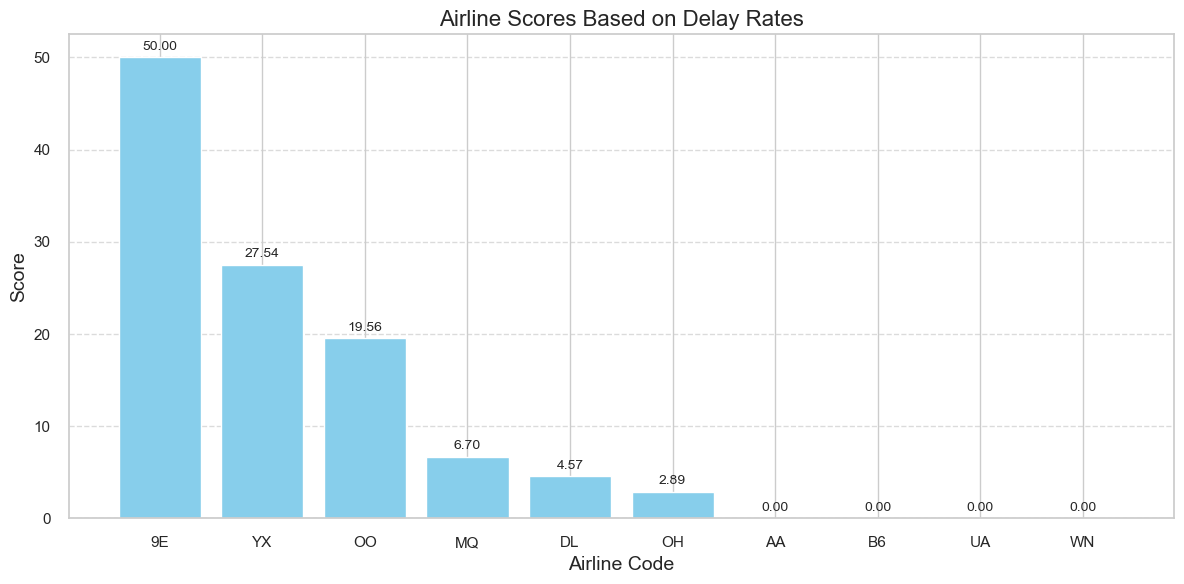

In [73]:
# 평균값 계산
avg_delayed_rate = delayed_rate_airline_season.mean()
min_value = delayed_rate_airline_season.min()

# 점수 계산 함수 정의
def score_function(delay_rate):
    if delay_rate < avg_delayed_rate:
        if delay_rate == min_value:
            return 50  # 가장 낮은 값을 가지는 항공사는 50점
        else:
            # min-max scaling 적용
            return 50 * (avg_delayed_rate - delay_rate) / (avg_delayed_rate - min_value)
    else:
        return 0  # 평균 이상이면 0점

# 각 항공사에 점수 부여
scores = delayed_rate_airline_season.apply(score_function)

# 점수 내림차순 정렬
scores_sorted = scores.sort_values(ascending=False)

# 결과 출력
print(scores_sorted)

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(scores_sorted.index, scores_sorted, color="skyblue")
plt.title("Airline Scores Based on Delay Rates", fontsize=16)
plt.xlabel("Airline Code", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 각 막대 위에 점수 추가
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()